In [1]:
import json
from datetime import datetime

import joblib
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
)

# Linear models
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split

# Naive Bayes

# KNN
from sklearn.preprocessing import label_binarize

# SVM models
from sklearn.svm import SVC

# Tree-based models
from utils import EmotionDataPreprocessor, load_fer2013_data

In [2]:
# 1. Load data (train split into train/val, and test)
print("Loading data...")
# Load original training data
X_train_full, y_train_full, emotion_labels = load_fer2013_data('Data_origin/train')
# Load test data
X_test, y_test, _ = load_fer2013_data('Data_origin/test')

# Split train into train and validation (80/20 split)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=y_train_full  # Maintain class distribution
)

print("Data loaded and split successfully!")
print(f"   Original train samples: {len(X_train_full)}")
print(f"   New train samples: {len(X_train)} ({len(X_train)/len(X_train_full)*100:.1f}%)")
print(f"   Validation samples: {len(X_val)} ({len(X_val)/len(X_train_full)*100:.1f}%)")
print(f"   Test samples: {len(X_test)}")

Loading data...
Loading and preprocessing images...
Processing angry: 3995 images


Loading angry: 100%|██████████| 3995/3995 [00:43<00:00, 91.54it/s] 


Processing disgust: 436 images


Loading disgust: 100%|██████████| 436/436 [00:04<00:00, 108.28it/s]


Processing fear: 4097 images


Loading fear: 100%|██████████| 4097/4097 [00:35<00:00, 114.08it/s]


Processing happy: 7215 images


Loading happy: 100%|██████████| 7215/7215 [00:51<00:00, 139.78it/s]


Processing sad: 4830 images


Loading sad: 100%|██████████| 4830/4830 [00:35<00:00, 134.23it/s]


Processing surprise: 3171 images


Loading surprise: 100%|██████████| 3171/3171 [00:21<00:00, 150.02it/s]


Processing neutral: 4965 images


Loading neutral: 100%|██████████| 4965/4965 [00:38<00:00, 127.94it/s]


Loading and preprocessing images...
Processing angry: 958 images


Loading angry: 100%|██████████| 958/958 [00:07<00:00, 136.73it/s]


Processing disgust: 111 images


Loading disgust: 100%|██████████| 111/111 [00:00<00:00, 125.47it/s]


Processing fear: 1024 images


Loading fear: 100%|██████████| 1024/1024 [00:07<00:00, 143.04it/s]


Processing happy: 1774 images


Loading happy: 100%|██████████| 1774/1774 [00:12<00:00, 137.14it/s]


Processing sad: 1247 images


Loading sad: 100%|██████████| 1247/1247 [00:09<00:00, 136.09it/s]


Processing surprise: 831 images


Loading surprise: 100%|██████████| 831/831 [00:05<00:00, 139.53it/s]


Processing neutral: 1233 images


Loading neutral: 100%|██████████| 1233/1233 [00:09<00:00, 130.31it/s]


Data loaded and split successfully!
   Original train samples: 28709
   New train samples: 22967 (80.0%)
   Validation samples: 5742 (20.0%)
   Test samples: 7178


In [3]:

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Emotion labels: {emotion_labels}")
preprocessor = EmotionDataPreprocessor(
    target_size=(64, 64),
    random_state=42
)

X_train_processed, train_info = preprocessor.fit_transform(
    X_train,
    pca_variance=0.95  
)

X_val_processed, val_info = preprocessor.transform(X_val)




Training set: (22967, 48, 48)
Validation set: (5742, 48, 48)
Test set: (7178, 48, 48)
Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

 TRAINING DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 22967/22967 [00:00<00:00, 100118.46it/s]



[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 22967/22967 [00:01<00:00, 14948.49it/s]



[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 22967/22967 [00:00<00:00, 125624.44it/s]



[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 22967/22967 [00:26<00:00, 867.97it/s]


    HOG shape: (22967, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/22967 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 22967/22967 [00:52<00:00, 435.52it/s]


    LBP shape: (22967, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 22967/22967 [00:38<00:00, 600.21it/s]


    SIFT shape: (22967, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (22967, 3684)
    - HOG: 1764 features
    - LBP: 640 features
    - SIFT: 1280 features
    - Total: 3684 features

[8/8] Standard Scaling and PCA
  → Fitting StandardScaler...
  → Fitting PCA (variance=0.95)...
    PCA reduced: 3684 → 1604 features
    Explained variance: 0.9501
    Number of components: 1604

 TRAINING PREPROCESSING COMPLETED
Final shape: (22967, 1604)
Original samples: 22967

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 5742/5742 [00:00<00:00, 36039.73it/s]


[2/8] CLAHE Enhancement


  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 5742/5742 [00:00<00:00, 15800.54it/s]



[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 5742/5742 [00:00<00:00, 62067.22it/s]



[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 5742/5742 [00:07<00:00, 727.05it/s]


    HOG shape: (5742, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/5742 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 5742/5742 [00:16<00:00, 350.90it/s]


    LBP shape: (5742, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 5742/5742 [00:10<00:00, 541.53it/s]


    SIFT shape: (5742, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (5742, 3684)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

 TEST PREPROCESSING COMPLETED
Final shape: (5742, 1604)
Original samples: 5742


# Logistic Regression 


STEP 1: BASELINE MODEL TRAINING

 Training baseline model...
   Parameters: C=1.0, penalty=l2, solver=lbfgs, max_iter=1000, class_weight=balanced


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   15.2s finished


Training completed!

 Training Set Performance:
   ROC-AUC (macro):     0.8684
   Accuracy:            0.5285
   F1-Score (macro):    0.5765
   F1-Score (weighted): 0.5267

 Validation Set Performance:
   ROC-AUC (macro):     0.7416
   Accuracy:            0.4014
   F1-Score (macro):    0.3608
   F1-Score (weighted): 0.4001

 Validation Classification Report:
              precision    recall  f1-score   support

       angry     0.2959    0.3104    0.3030       799
     disgust     0.1761    0.2874    0.2183        87
        fear     0.2835    0.2683    0.2757       820
       happy     0.6140    0.5877    0.6006      1443
         sad     0.3228    0.2743    0.2966       966
    surprise     0.4018    0.5615    0.4684       634
     neutral     0.3820    0.3454    0.3628       993

    accuracy                         0.4014      5742
   macro avg     0.3537    0.3764    0.3608      5742
weighted avg     0.4034    0.4014    0.4001      5742



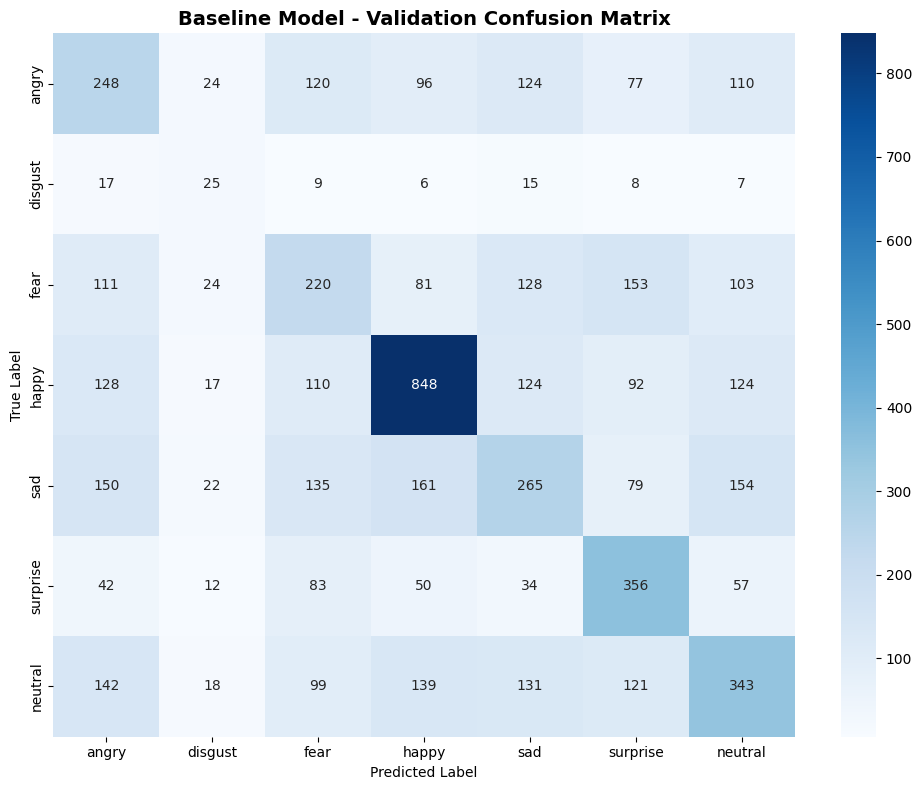


 BASELINE MODEL EVALUATION COMPLETED

 Baseline Performance Summary:
   Training ROC-AUC:   0.8684
   Validation ROC-AUC: 0.7416
   Difference:         0.1268


In [4]:
# STEP 1: Train baseline model with default parameters
print("\n" + "="*70)
print("STEP 1: BASELINE MODEL TRAINING")
print("="*70)


baseline_model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    multi_class='ovr',
    n_jobs=-1,
    verbose=1
)

print("\n Training baseline model...")
print("   Parameters: C=1.0, penalty=l2, solver=lbfgs, max_iter=1000, class_weight=balanced")

baseline_model.fit(X_train_processed, y_train)
print("Training completed!")

# Evaluate on training set
print("\n Training Set Performance:")
y_train_pred = baseline_model.predict(X_train_processed)
y_train_pred_proba = baseline_model.predict_proba(X_train_processed)

n_classes = len(emotion_labels)
y_train_bin = label_binarize(y_train, classes=range(n_classes))

train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
train_roc_auc = roc_auc_score(y_train_bin, y_train_pred_proba, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {train_roc_auc:.4f}")
print(f"   Accuracy:            {train_accuracy:.4f}")
print(f"   F1-Score (macro):    {train_f1_macro:.4f}")
print(f"   F1-Score (weighted): {train_f1_weighted:.4f}")

# Evaluate on validation set
print("\n Validation Set Performance:")
y_val_pred = baseline_model.predict(X_val_processed)
y_val_pred_proba = baseline_model.predict_proba(X_val_processed)

y_val_bin = label_binarize(y_val, classes=range(n_classes))

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
val_roc_auc = roc_auc_score(y_val_bin, y_val_pred_proba, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {val_roc_auc:.4f}")
print(f"   Accuracy:            {val_accuracy:.4f}")
print(f"   F1-Score (macro):    {val_f1_macro:.4f}")
print(f"   F1-Score (weighted): {val_f1_weighted:.4f}")

# Classification report
print("\n Validation Classification Report:")
report = classification_report(y_val, y_val_pred, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_val, y_val_pred, target_names=emotion_labels, digits=4))

# Confusion matrix visualization
cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Baseline Model - Validation Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix as artifact
cm_path = "baseline_confusion_matrix.png"
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

# Store baseline results
baseline_results = {
    'train': {
        'roc_auc': train_roc_auc,
        'accuracy': train_accuracy,
        'f1_macro': train_f1_macro,
        'f1_weighted': train_f1_weighted
    },
    'validation': {
        'roc_auc': val_roc_auc,
        'accuracy': val_accuracy,
        'f1_macro': val_f1_macro,
        'f1_weighted': val_f1_weighted
    }
}

# Log baseline results as JSON artifact
baseline_json = "baseline_results.json"
with open(baseline_json, 'w') as f:
    json.dump(baseline_results, f, indent=4)


print("\n" + "="*70)
print(" BASELINE MODEL EVALUATION COMPLETED")
print("="*70)
print("\n Baseline Performance Summary:")
print(f"   Training ROC-AUC:   {train_roc_auc:.4f}")
print(f"   Validation ROC-AUC: {val_roc_auc:.4f}")
print(f"   Difference:         {abs(train_roc_auc - val_roc_auc):.4f}")

# Log overfitting metric
overfitting_gap = train_roc_auc - val_roc_auc


if train_roc_auc - val_roc_auc > 0.05:
    print("     Warning: Possible overfitting detected!")
    

In [5]:
# STEP 2: Hyperparameter Tuning with GridSearchCV (Demo - 10 combinations)
print("\n" + "="*70)
print(" STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*70)

from sklearn.model_selection import GridSearchCV

# Reduced hyperparameter grid for demo (max 10 combinations)
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [1000],
    'class_weight': ['balanced']
}

print("\n Parameter Grid (Demo - Limited Combinations):")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

total_combinations = len(param_grid['C']) * len(param_grid['penalty']) * len(param_grid['solver']) * len(param_grid['max_iter']) * len(param_grid['class_weight'])
print(f"\nTotal combinations to test: {total_combinations}")
print(f"Baseline ROC-AUC to beat: {val_roc_auc:.4f}\n")

# Create parent run for hyperparameter tuning

    




# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, multi_class='ovr', n_jobs=-1),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation on training data
    scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Fit GridSearchCV
print(" Running GridSearchCV...")
grid_search.fit(X_train_processed, y_train)
print(" GridSearchCV completed!")

# Get results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')



results_list = []
best_roc_auc = val_roc_auc
best_model = baseline_model
best_run_id = None

for idx in range(len(cv_results)):
    row = cv_results.iloc[idx]
    
    
        
    # Extract parameters
    params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
    
    
    
    # Train model with these parameters on full training set
    model = LogisticRegression(**params, random_state=42, multi_class='ovr', n_jobs=-1)
    model.fit(X_train_processed, y_train)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val_processed)
    y_val_pred_proba = model.predict_proba(X_val_processed)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val_bin, y_val_pred_proba, average='macro', multi_class='ovr')
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    
    
    
    # Store results
    result = {
        
        **params,
        'cv_mean_score': row['mean_test_score'],
        'cv_std_score': row['std_test_score'],
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    results_list.append(result)
    
    # Update best model
    if roc_auc > best_roc_auc:
        improvement = roc_auc - best_roc_auc
        best_roc_auc = roc_auc
        best_model = model
        
        best_params = params
        best_metrics = {
            'val_roc_auc': roc_auc,
            'val_accuracy': accuracy,
            'val_f1_macro': f1_macro,
            'val_f1_weighted': f1_weighted
        }
        
       
        
        
        
        print(f" New best model found! (+{improvement:.4f})")
        print(f"   ROC-AUC: {roc_auc:.4f} | Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
        print(f"   CV Score: {row['mean_test_score']:.4f}")
        print(f"   Params: {params}")
        





# Save CV results
cv_results_path = "gridsearch_cv_results.csv"
cv_results.to_csv(cv_results_path, index=False)


print("\n" + "="*70)
print(" GRIDSEARCHCV HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement = best_roc_auc - baseline_results['validation']['roc_auc']
print("\n Tuning Results:")
print(f"   Baseline ROC-AUC:     {baseline_results['validation']['roc_auc']:.4f}")
print(f"   Best CV ROC-AUC:      {grid_search.best_score_:.4f}")
print(f"   Best Val ROC-AUC:     {best_roc_auc:.4f}")
print(f"   Improvement:          {improvement:.4f} ({improvement/baseline_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Total combinations:   {total_combinations}")



 STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV

 Parameter Grid (Demo - Limited Combinations):
   C: [0.1, 1.0, 10.0]
   penalty: ['l2']
   solver: ['lbfgs', 'saga']
   max_iter: [1000]
   class_weight: ['balanced']

Total combinations to test: 6
Baseline ROC-AUC to beat: 0.7416

 Running GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


 GridSearchCV completed!


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


 New best model found! (+0.0008)
   ROC-AUC: 0.7424 | Accuracy: 0.4016 | F1-Macro: 0.3603
   CV Score: 0.7184
   Params: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 New best model found! (+0.0000)
   ROC-AUC: 0.7424 | Accuracy: 0.4023 | F1-Macro: 0.3632
   CV Score: 0.7147
   Params: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\n


 GRIDSEARCHCV HYPERPARAMETER TUNING COMPLETED

 Tuning Results:
   Baseline ROC-AUC:     0.7416
   Best CV ROC-AUC:      0.7184
   Best Val ROC-AUC:     0.7424
   Improvement:          0.0008 (0.11%)
   Total combinations:   6



 TOP 10 MODELS BY ROC-AUC:
   C class_weight  max_iter penalty solver  cv_mean_score  cv_std_score  roc_auc  accuracy  f1_macro  f1_weighted
 0.1     balanced      1000      l2   saga       0.714707      0.003122 0.742441  0.402299  0.363236     0.400751
 0.1     balanced      1000      l2  lbfgs       0.718397      0.002542 0.742414  0.401602  0.360259     0.400274
 1.0     balanced      1000      l2   saga       0.712882      0.003239 0.741693  0.401602  0.361895     0.400300
 1.0     balanced      1000      l2  lbfgs       0.714995      0.003248 0.741638  0.401428  0.360767     0.400119
10.0     balanced      1000      l2   saga       0.712673      0.003245 0.741610  0.401428  0.361735     0.400130
10.0     balanced      1000      l2  lbfgs       0.709979      0.004294 0.740921  0.403518  0.365825     0.401762


C:\Users\nguye\AppData\Local\Temp\ipykernel_25556\1712336227.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(penalty_comparison.values(), labels=penalty_comparison.keys())
C:\Users\nguye\AppData\Local\Temp\ipykernel_25556\1712336227.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(solver_comparison.values(), labels=solver_comparison.keys())


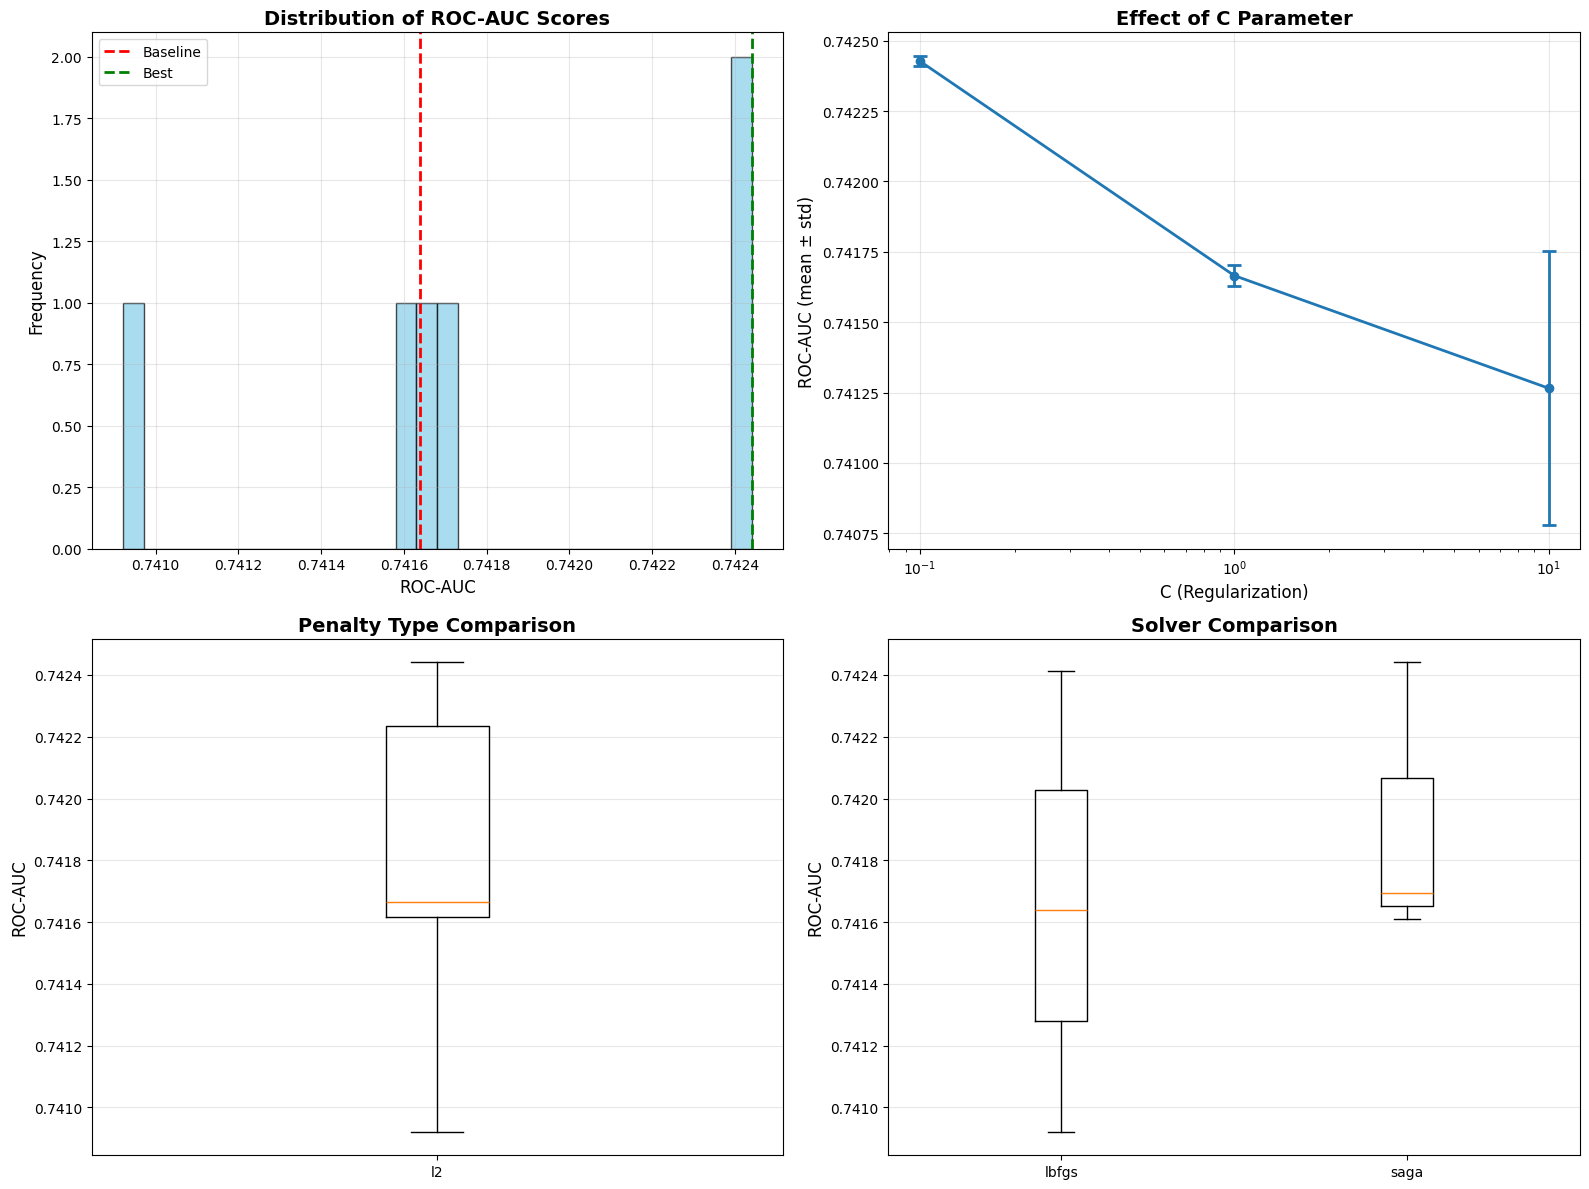


 BEST MODEL PARAMETERS

Best Parameters:
  C: 0.1
  class_weight: balanced
  max_iter: 1000
  penalty: l2
  solver: saga

Validation Metrics:
  val_roc_auc: 0.7424
  val_accuracy: 0.4023
  val_f1_macro: 0.3632
  val_f1_weighted: 0.4008


In [6]:



results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('roc_auc', ascending=False)

print("\n TOP 10 MODELS BY ROC-AUC:")
print(results_df.head(10).to_string(index=False))

# Save results to CSV and log as artifact
results_csv = "tuning_results.csv"
results_df.to_csv(results_csv, index=False)


# Visualize tuning results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC-AUC distribution
ax1 = axes[0, 0]
ax1.hist(results_df['roc_auc'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(baseline_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.axvline(best_roc_auc, color='green', linestyle='--', linewidth=2, label='Best')
ax1.set_xlabel('ROC-AUC', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of ROC-AUC Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. C parameter effect
ax2 = axes[0, 1]
c_effect = results_df.groupby('C')['roc_auc'].agg(['mean', 'std']).reset_index()
ax2.errorbar(c_effect['C'], c_effect['mean'], yerr=c_effect['std'], marker='o', capsize=5, capthick=2, linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('C (Regularization)', fontsize=12)
ax2.set_ylabel('ROC-AUC (mean ± std)', fontsize=12)
ax2.set_title('Effect of C Parameter', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

# 3. Penalty comparison
ax3 = axes[1, 0]
penalty_comparison = results_df.groupby('penalty')['roc_auc'].apply(list).to_dict()
ax3.boxplot(penalty_comparison.values(), labels=penalty_comparison.keys())
ax3.set_ylabel('ROC-AUC', fontsize=12)
ax3.set_title('Penalty Type Comparison', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# 4. Solver comparison
ax4 = axes[1, 1]
solver_comparison = results_df.groupby('solver')['roc_auc'].apply(list).to_dict()
ax4.boxplot(solver_comparison.values(), labels=solver_comparison.keys())
ax4.set_ylabel('ROC-AUC', fontsize=12)
ax4.set_title('Solver Comparison', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

plt.tight_layout()

# Log visualization as artifact
tuning_viz_path = 'hyperparameter_tuning_analysis.png'
plt.savefig(tuning_viz_path, dpi=300, bbox_inches='tight')

plt.show()

print("\n" + "="*70)
print(" BEST MODEL PARAMETERS")
print("="*70)
print("\nBest Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print("\nValidation Metrics:")
for key, value in best_metrics.items():
    print(f"  {key}: {value:.4f}")




 FINAL EVALUATION ON TEST SET

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter:   0%|          | 0/7178 [00:00<?, ?it/s]

Median Filter: 100%|██████████| 7178/7178 [00:00<00:00, 17103.92it/s]



[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 7178/7178 [00:00<00:00, 15553.82it/s]



[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 7178/7178 [00:00<00:00, 110806.22it/s]



[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 7178/7178 [00:10<00:00, 693.74it/s]


    HOG shape: (7178, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/7178 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 7178/7178 [00:22<00:00, 320.15it/s]


    LBP shape: (7178, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 7178/7178 [00:11<00:00, 623.60it/s]


    SIFT shape: (7178, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (7178, 3684)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

 TEST PREPROCESSING COMPLETED
Final shape: (7178, 1604)
Original samples: 7178

Test Set Metrics:
  ROC-AUC (macro):     0.7402
  Accuracy:            0.4018
  F1-Score (macro):    0.3668
  F1-Score (weighted): 0.3993

 Test Classification Report:
              precision    recall  f1-score   support

       angry     0.2893    0.2996    0.2944       958
     disgust     0.2182    0.3243    0.2609       111
        fear     0.2581    0.2422    0.2499      1024
       happy     0.6091    0.5930    0.6010      1774
         sad     0.2988    0.2614    0.2789      1247
    surprise     0.4473    0.5824    0.5060       831
     neutral     0.3888    0.3658    0.3769      1233

    accuracy                         0.4018      7178
   macro avg     0.3585    0.3812    0.3668      7178
weigh

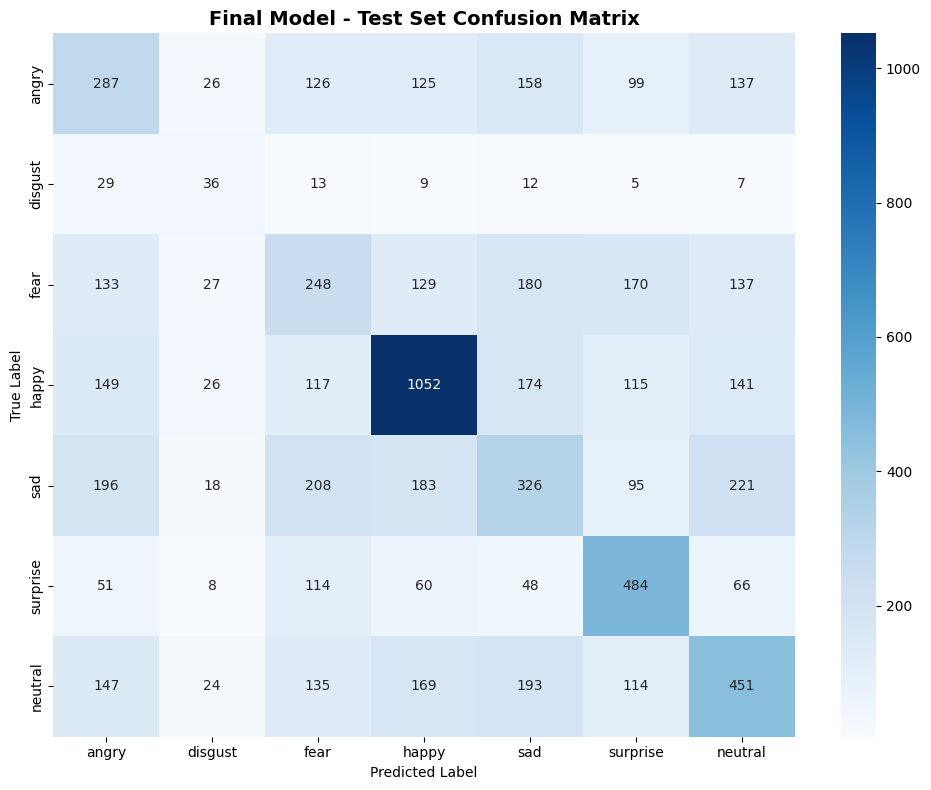

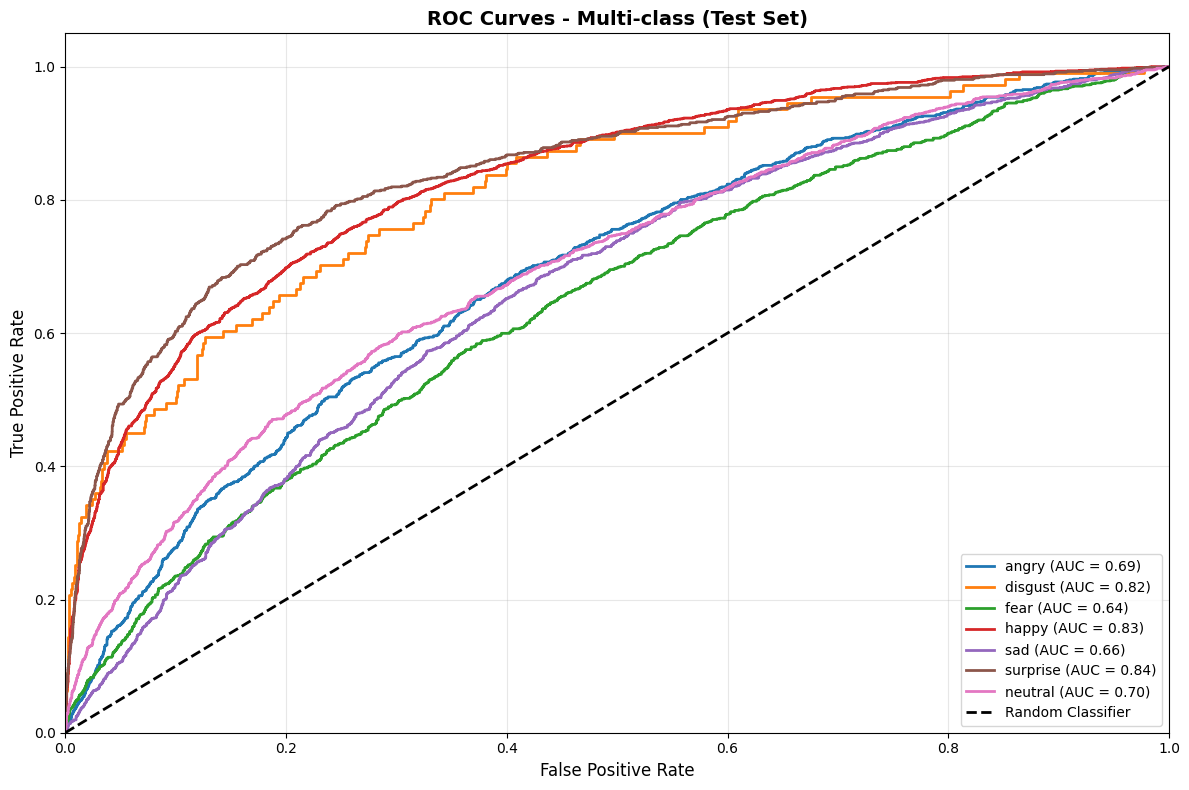


 Per-Class Metrics:
 Emotion  Precision   Recall  F1-Score  Support
   angry   0.289315 0.299582  0.294359      958
 disgust   0.218182 0.324324  0.260870      111
    fear   0.258065 0.242188  0.249874     1024
   happy   0.609149 0.593010  0.600971     1774
     sad   0.298808 0.261427  0.278871     1247
surprise   0.447320 0.582431  0.506012      831
 neutral   0.388793 0.365775  0.376933     1233

 Model saved: models/logistic_regression_best_20251112_042034.pkl
 Results saved: models/logistic_regression_results_20251112_042034.json

 TRAINING PIPELINE COMPLETED SUCCESSFULLY

 Final Test Performance:
  ROC-AUC:  0.7402
  Accuracy: 0.4018
  F1-Score: 0.3668
 Model saved as: models/logistic_regression_best_20251112_042034.pkl


In [7]:

print("\n" + "="*70)
print(" FINAL EVALUATION ON TEST SET")
print("="*70)


    




# Preprocess test data
X_test_processed, test_info = preprocessor.transform(X_test)

# Predict on test set
y_test_pred = best_model.predict(X_test_processed)
y_test_pred_proba = best_model.predict_proba(X_test_processed)

y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Calculate all metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
test_roc_auc = roc_auc_score(y_test_bin, y_test_pred_proba, average='macro', multi_class='ovr')

print("\nTest Set Metrics:")
print(f"  ROC-AUC (macro):     {test_roc_auc:.4f}")
print(f"  Accuracy:            {test_accuracy:.4f}")
print(f"  F1-Score (macro):    {test_f1_macro:.4f}")
print(f"  F1-Score (weighted): {test_f1_weighted:.4f}")



# Classification report
print("\n Test Classification Report:")
report = classification_report(y_test, y_test_pred, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_test, y_test_pred, target_names=emotion_labels, digits=4))



# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Final Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix
test_cm_path = 'test_confusion_matrix.png'
plt.savefig(test_cm_path, dpi=300, bbox_inches='tight')

plt.show()

# ROC Curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_proba[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
    
  

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Log ROC curves
roc_path = 'test_roc_curves.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')

plt.show()

# Per-class metrics table
print("\n Per-Class Metrics:")
class_metrics = []
for i, emotion in enumerate(emotion_labels):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_metrics.append({
        'Emotion': emotion,
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-Score': float(f1),
        'Support': int(cm[i, :].sum())
    })

class_metrics_df = pd.DataFrame(class_metrics)
print(class_metrics_df.to_string(index=False))

# Save and log class metrics
class_metrics_csv = "test_class_metrics.csv"
class_metrics_df.to_csv(class_metrics_csv, index=False)


# Save final model 
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'models/logistic_regression_best_{timestamp}.pkl'
#bi thieu chua tao folder nay
joblib.dump(best_model, model_filename)
print(f"\n Model saved: {model_filename}")




# Save complete results
# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

final_results = {
    'model_name': 'Logistic Regression',
    'timestamp': timestamp,
    'best_params': convert_to_native_types(best_params),
    
    'validation_metrics': convert_to_native_types(best_metrics),
    'test_metrics': {
        'roc_auc': float(test_roc_auc),
        'accuracy': float(test_accuracy),
        'f1_macro': float(test_f1_macro),
        'f1_weighted': float(test_f1_weighted)
    },
    'per_class_metrics': class_metrics,
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test)),
    'feature_dimension': int(X_train_processed.shape[1]),
    'emotion_labels': emotion_labels
}

results_filename = f'models/logistic_regression_results_{timestamp}.json'
with open(results_filename, 'w') as f:
    json.dump(final_results, f, indent=4)
print(f" Results saved: {results_filename}")



print("\n" + "="*70)
print(" TRAINING PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print("\n Final Test Performance:")
print(f"  ROC-AUC:  {test_roc_auc:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  F1-Score: {test_f1_macro:.4f}")

print(f" Model saved as: {model_filename}")


# Random forest


 STEP 1: BASELINE RANDOM FOREST MODEL TRAINING

 Training baseline Random Forest...
   Parameters: n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   49.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


 Training completed!

 Training Set Performance:


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


   ROC-AUC (macro):     0.9999
   Accuracy:            0.9987
   F1-Score (macro):    0.9981
   F1-Score (weighted): 0.9987

 Validation Set Performance:


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 300 out of 300 | elapsed:    0.1s finished


   ROC-AUC (macro):     0.7015
   Accuracy:            0.3344
   F1-Score (macro):    0.2538
   F1-Score (weighted): 0.2570

 Validation Classification Report:
              precision    recall  f1-score   support

       angry     0.7377    0.0563    0.1047       799
     disgust     0.9474    0.2069    0.3396        87
        fear     0.7653    0.0915    0.1634       820
       happy     0.2912    0.9751    0.4484      1443
         sad     0.4044    0.0766    0.1288       966
    surprise     0.9860    0.2224    0.3629       634
     neutral     0.3941    0.1611    0.2287       993

    accuracy                         0.3344      5742
   macro avg     0.6466    0.2557    0.2538      5742
weighted avg     0.5445    0.3344    0.2570      5742



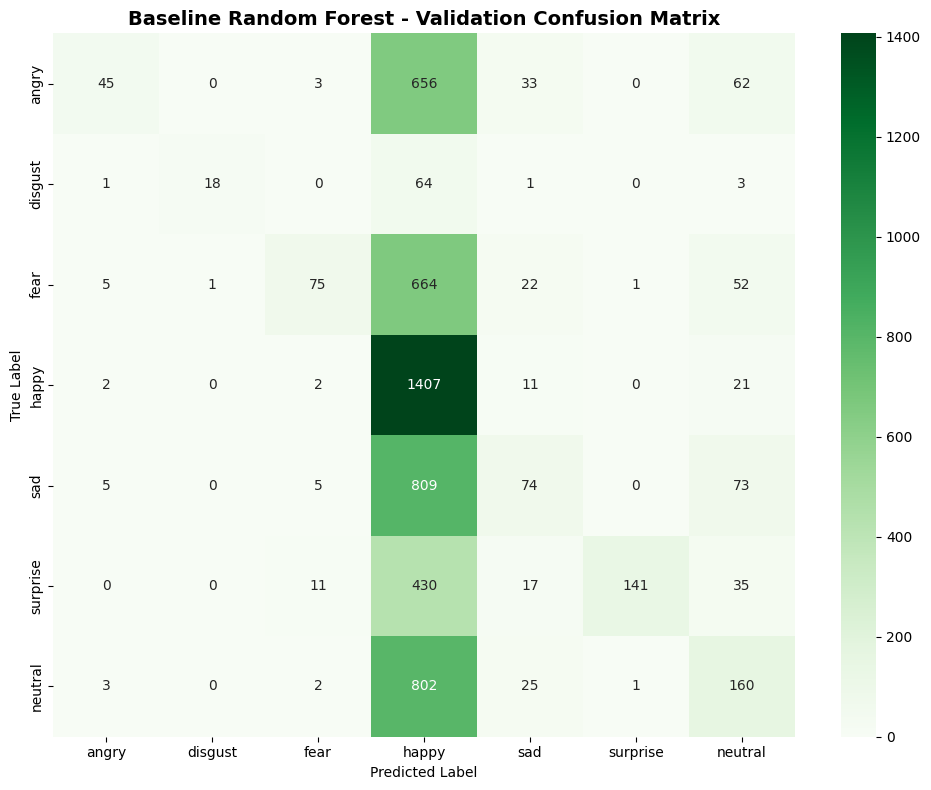

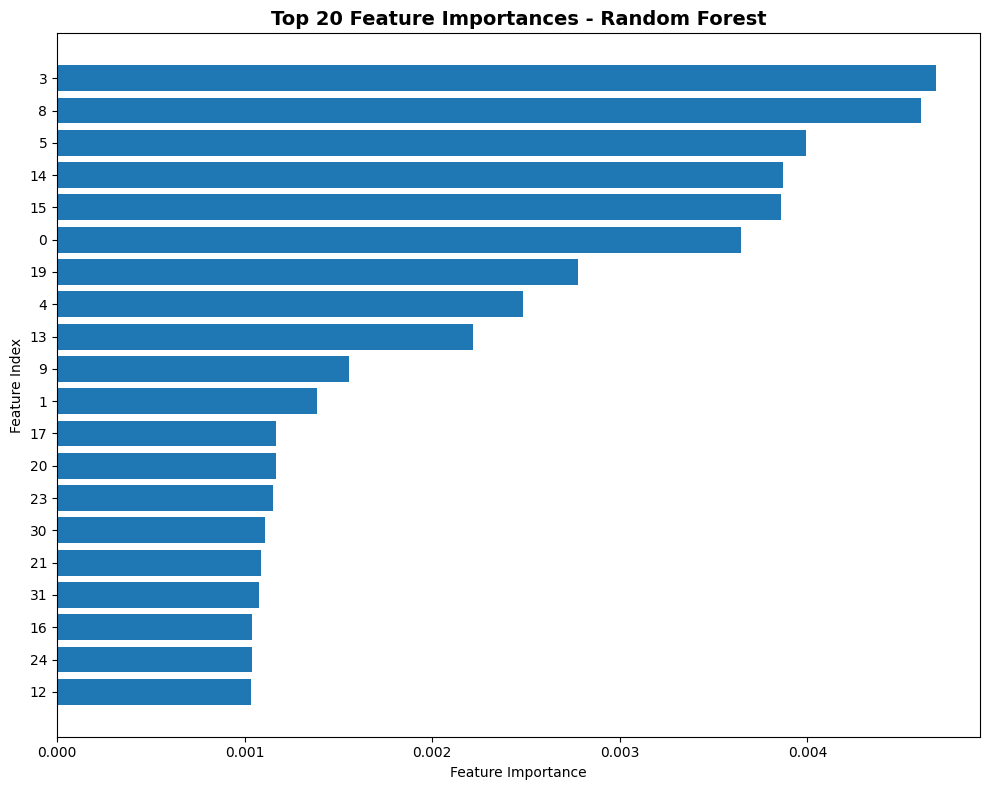


 BASELINE RANDOM FOREST MODEL EVALUATION COMPLETED

 Baseline Performance Summary:
   Training ROC-AUC:   0.9999
   Validation ROC-AUC: 0.7015
   Difference:         0.2985


In [8]:
# STEP 1: Train baseline Random Forest model
print("\n" + "="*70)
print(" STEP 1: BASELINE RANDOM FOREST MODEL TRAINING")
print("="*70)



# -------- Khởi tạo model (NHẤT QUÁN VỚI LOG) --------
baseline_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,  
    min_samples_leaf=2,
    max_features="sqrt",   
    random_state=42,
    n_jobs=-1,
    verbose=1
)



print("\n Training baseline Random Forest...")
print("   Parameters: n_estimators=300, max_depth=20, min_samples_split=5, "
        "min_samples_leaf=2, max_features=sqrt")

baseline_rf.fit(X_train_processed, y_train)
print(" Training completed!")

# -------- Chuẩn bị cho ROC-AUC đa lớp --------
n_classes_rf   = len(emotion_labels)
y_train_bin_rf = label_binarize(y_train, classes=range(n_classes_rf))
y_val_bin_rf   = label_binarize(y_val,   classes=range(n_classes_rf))

# ===================== TRAIN METRICS =====================
print("\n Training Set Performance:")
y_train_pred_rf       = baseline_rf.predict(X_train_processed)
y_train_pred_proba_rf = baseline_rf.predict_proba(X_train_processed)

train_accuracy_rf     = accuracy_score(y_train, y_train_pred_rf)
train_f1_macro_rf     = f1_score(y_train, y_train_pred_rf, average='macro')
train_f1_weighted_rf  = f1_score(y_train, y_train_pred_rf, average='weighted')
train_roc_auc_rf      = roc_auc_score(
    y_train_bin_rf, y_train_pred_proba_rf, average='macro', multi_class='ovr'
)

print(f"   ROC-AUC (macro):     {train_roc_auc_rf:.4f}")
print(f"   Accuracy:            {train_accuracy_rf:.4f}")
print(f"   F1-Score (macro):    {train_f1_macro_rf:.4f}")
print(f"   F1-Score (weighted): {train_f1_weighted_rf:.4f}")


# ===================== VAL METRICS =====================
print("\n Validation Set Performance:")
y_val_pred_rf       = baseline_rf.predict(X_val_processed)
y_val_pred_proba_rf = baseline_rf.predict_proba(X_val_processed)

val_accuracy_rf     = accuracy_score(y_val, y_val_pred_rf)
val_f1_macro_rf     = f1_score(y_val, y_val_pred_rf, average='macro')
val_f1_weighted_rf  = f1_score(y_val, y_val_pred_rf, average='weighted')
val_roc_auc_rf      = roc_auc_score(
    y_val_bin_rf, y_val_pred_proba_rf, average='macro', multi_class='ovr'
)

print(f"   ROC-AUC (macro):     {val_roc_auc_rf:.4f}")
print(f"   Accuracy:            {val_accuracy_rf:.4f}")
print(f"   F1-Score (macro):    {val_f1_macro_rf:.4f}")
print(f"   F1-Score (weighted): {val_f1_weighted_rf:.4f}")



# ===================== REPORT & CONFUSION MATRIX =====================
print("\n Validation Classification Report:")
report_rf = classification_report(
    y_val, y_val_pred_rf, target_names=emotion_labels, digits=4, output_dict=True
)
print(classification_report(y_val, y_val_pred_rf, target_names=emotion_labels, digits=4))



# Confusion matrix
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Baseline Random Forest - Validation Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.tight_layout()
cm_path_rf = "baseline_rf_confusion_matrix.png"
plt.savefig(cm_path_rf, dpi=300, bbox_inches='tight')

plt.show()

fi = baseline_rf.feature_importances_
top_n = min(20, fi.shape[0])
top_idx = np.argsort(fi)[-top_n:]
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), fi[top_idx])
plt.yticks(range(top_n), top_idx)
plt.xlabel('Feature Importance'); plt.ylabel('Feature Index')
plt.title(f'Top {top_n} Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
fi_path = "baseline_rf_feature_importance.png"
plt.savefig(fi_path, dpi=300, bbox_inches='tight')

plt.show()


baseline_rf_results = {
    "train": {
        "roc_auc": float(train_roc_auc_rf),
        "accuracy": float(train_accuracy_rf),
        "f1_macro": float(train_f1_macro_rf),
        "f1_weighted": float(train_f1_weighted_rf)
    },
    "validation": {
        "roc_auc": float(val_roc_auc_rf),
        "accuracy": float(val_accuracy_rf),
        "f1_macro": float(val_f1_macro_rf),
        "f1_weighted": float(val_f1_weighted_rf)
    }
}
baseline_rf_json = "baseline_rf_results.json"
with open(baseline_rf_json, "w") as f:
    json.dump(baseline_rf_results, f, indent=4)


print("\n" + "="*70)
print(" BASELINE RANDOM FOREST MODEL EVALUATION COMPLETED")
print("="*70)
print("\n Baseline Performance Summary:")
print(f"   Training ROC-AUC:   {train_roc_auc_rf:.4f}")
print(f"   Validation ROC-AUC: {val_roc_auc_rf:.4f}")
print(f"   Difference:         {abs(train_roc_auc_rf - val_roc_auc_rf):.4f}")

# Overfitting gap
overfitting_gap_rf = float(train_roc_auc_rf - val_roc_auc_rf)

if overfitting_gap_rf > 0.05:
    print("     Warning: Possible overfitting detected!")
    




In [9]:
# STEP 2: Hyperparameter Tuning for Random Forest using RandomizedSearchCV (Demo)
print("\n" + "="*70)
print(" STEP 2: HYPERPARAMETER TUNING FOR RANDOM FOREST")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

# Reduced hyperparameter distributions for demo (faster execution)
param_distributions_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15 ],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\n Parameter Distributions (Demo - Limited for faster execution):")
for param, dist in param_distributions_rf.items():
    print(f"   {param}: {dist}")

n_iter = 10  # Number of random combinations to try (reduced for demo)
print(f"\nRandomized Search iterations: {n_iter} (demo mode)")
print(f"Baseline ROC-AUC to beat: {val_roc_auc_rf:.4f}\n")




# Create RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions_rf,
    n_iter=n_iter,
    cv=3,  # 3-fold cross-validation on training data
    scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV
print(" Running RandomizedSearchCV (should complete in a few minutes)...")
rf_random.fit(X_train_processed, y_train)
print(" RandomizedSearchCV completed!")

# Get results
cv_results = pd.DataFrame(rf_random.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')

# Log all results as nested runs (since we only have ~10 iterations)


results_list_rf = []
best_roc_auc_rf = val_roc_auc_rf
best_rf_model = baseline_rf
best_run_id_rf = None
best_params_rf = {}  # Initialize to prevent NameError
best_metrics_rf = {  # Initialize with baseline metrics
    'val_roc_auc': val_roc_auc_rf,
    'val_accuracy': val_accuracy_rf,
    'val_f1_macro': val_f1_macro_rf,
    'val_f1_weighted': val_f1_weighted_rf
}

for idx in range(len(cv_results)):
    row = cv_results.iloc[idx]
    
    
    
    params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
    
    # Log parameters
    
    
    # Get the model from CV
    model_idx = row['rank_test_score'] - 1
    model_rf = rf_random.cv_results_['params'][model_idx]
    fitted_model = RandomForestClassifier(**model_rf, random_state=42, n_jobs=-1)
    fitted_model.fit(X_train_processed, y_train)
    
    # Evaluate on validation set
    y_val_pred = fitted_model.predict(X_val_processed)
    y_val_pred_proba = fitted_model.predict_proba(X_val_processed)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val_bin_rf, y_val_pred_proba, average='macro', multi_class='ovr')
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    
    # Log metrics
    
    
    # Store results
    result = {
        
        **params,
        'cv_mean_score': row['mean_test_score'],
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    results_list_rf.append(result)
    
    # Update best model
    if roc_auc > best_roc_auc_rf:
        improvement = roc_auc - best_roc_auc_rf
        best_roc_auc_rf = roc_auc
        best_rf_model = fitted_model
        
        best_params_rf = params
        best_metrics_rf = {
            'val_roc_auc': roc_auc,
            'val_accuracy': accuracy,
            'val_f1_macro': f1_macro,
            'val_f1_weighted': f1_weighted
        }
        
        
        
        print(f" New best RF model found! (+{improvement:.4f})")
        print(f"   ROC-AUC: {roc_auc:.4f} | Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
        print(f"   CV Score: {row['mean_test_score']:.4f}")
     




# Save CV results
cv_results_path = "rf_cv_results.csv"
cv_results.to_csv(cv_results_path, index=False)


print("\n" + "="*70)
print(" RANDOMIZED HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement_rf = best_roc_auc_rf - baseline_rf_results['validation']['roc_auc']
print("\n Tuning Results:")
print(f"   Baseline ROC-AUC:     {baseline_rf_results['validation']['roc_auc']:.4f}")
print(f"   Best CV ROC-AUC:      {rf_random.best_score_:.4f}")
print(f"   Best Val ROC-AUC:     {best_roc_auc_rf:.4f}")
print(f"   Improvement:          {improvement_rf:.4f} ({improvement_rf/baseline_rf_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Iterations completed: {n_iter}")



 STEP 2: HYPERPARAMETER TUNING FOR RANDOM FOREST

 Parameter Distributions (Demo - Limited for faster execution):
   n_estimators: [50, 100, 150]
   max_depth: [10, 15]
   min_samples_split: [2, 5, 10]
   min_samples_leaf: [1, 2, 4]
   max_features: ['sqrt', 'log2']

Randomized Search iterations: 10 (demo mode)
Baseline ROC-AUC to beat: 0.7015

 Running RandomizedSearchCV (should complete in a few minutes)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
 RandomizedSearchCV completed!
 New best RF model found! (+0.0025)
   ROC-AUC: 0.7039 | Accuracy: 0.2828 | F1-Macro: 0.1163
   CV Score: 0.6039

 RANDOMIZED HYPERPARAMETER TUNING COMPLETED

 Tuning Results:
   Baseline ROC-AUC:     0.7015
   Best CV ROC-AUC:      0.6842
   Best Val ROC-AUC:     0.7039
   Improvement:          0.0025 (0.35%)
   Iterations completed: 10



 TOP 10 RANDOM FOREST MODELS BY VALIDATION ROC-AUC:
 cv_mean_score  roc_auc  accuracy  f1_macro  n_estimators  max_depth  min_samples_split
      0.603851 0.703930  0.282828  0.116291            50         10                  5
      0.668521 0.693943  0.284222  0.119606           100         10                  2
      0.678133 0.691783  0.287530  0.125941           100         10                  5
      0.684239 0.691307  0.326193  0.204541           150         10                  2
      0.667467 0.673331  0.327760  0.205701           150         15                  5
      0.643201 0.666826  0.328805  0.221137           100         15                  5
      0.606731 0.634587  0.298154  0.155866            50         10                  2
      0.668059 0.629430  0.305817  0.176605           150         15                 10
      0.614930 0.625358  0.258272  0.072283           150         15                  2
      0.616466 0.614549  0.259143  0.073584           150         1

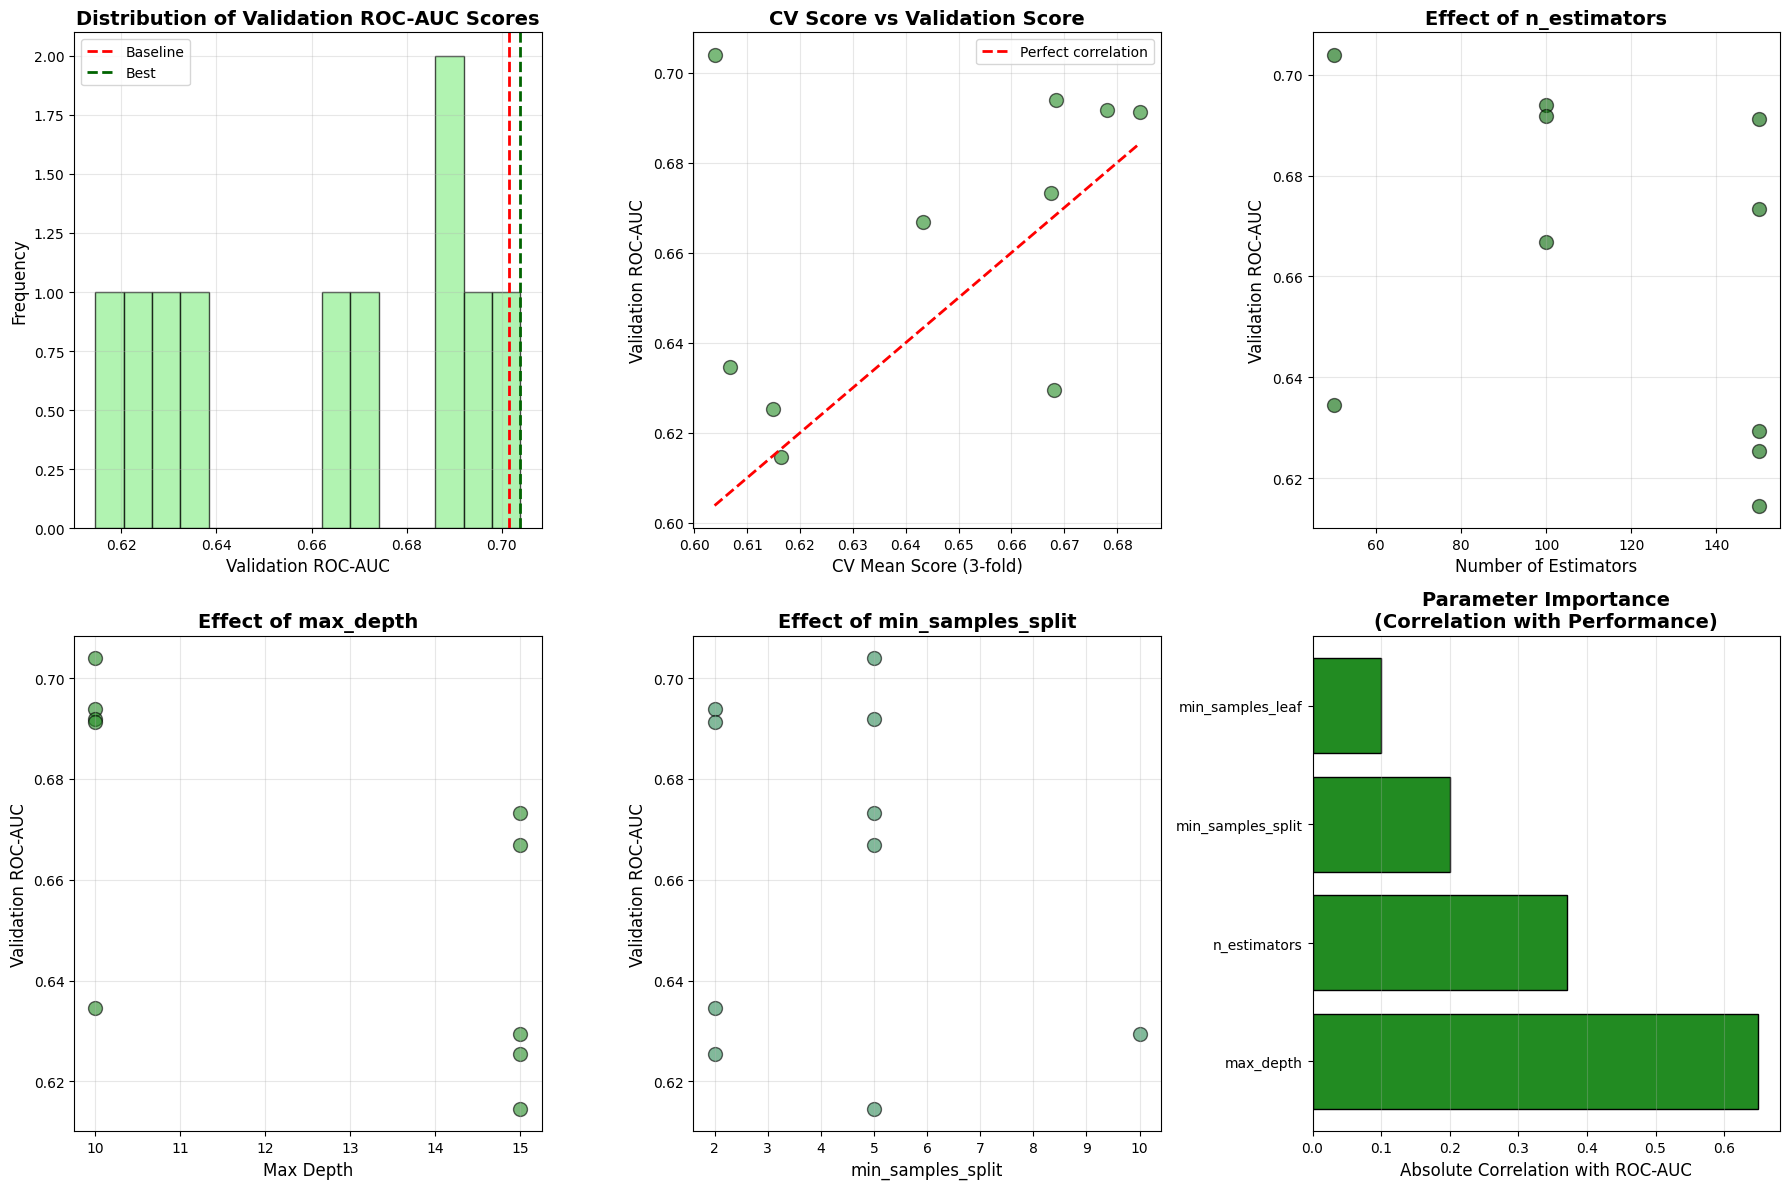


 BEST RANDOM FOREST MODEL PARAMETERS (from RandomizedSearchCV)

Best Parameters:
  n_estimators: 50
  min_samples_split: 5
  min_samples_leaf: 1
  max_features: log2
  max_depth: 10

Validation Metrics:
  val_roc_auc: 0.7039
  val_accuracy: 0.2828
  val_f1_macro: 0.1163
  val_f1_weighted: 0.1642


In [10]:

results_df_rf = pd.DataFrame(results_list_rf)
results_df_rf = results_df_rf.sort_values('roc_auc', ascending=False)

print("\n TOP 10 RANDOM FOREST MODELS BY VALIDATION ROC-AUC:")
display_cols = ['cv_mean_score', 'roc_auc', 'accuracy', 'f1_macro', 'n_estimators', 'max_depth', 'min_samples_split']
available_cols = [col for col in display_cols if col in results_df_rf.columns]
print(results_df_rf[available_cols].head(10).to_string(index=False))

# Save results to CSV and log as artifact
results_csv_rf = "rf_randomized_search_results.csv"
results_df_rf.to_csv(results_csv_rf, index=False)


# Visualize tuning results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. ROC-AUC distribution
ax1 = axes[0, 0]
ax1.hist(results_df_rf['roc_auc'], bins=15, edgecolor='black', alpha=0.7, color='lightgreen')
ax1.axvline(baseline_rf_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.axvline(best_roc_auc_rf, color='darkgreen', linestyle='--', linewidth=2, label='Best')
ax1.set_xlabel('Validation ROC-AUC', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Validation ROC-AUC Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. CV Score vs Validation Score
ax2 = axes[0, 1]
ax2.scatter(results_df_rf['cv_mean_score'], results_df_rf['roc_auc'], 
            alpha=0.6, s=100, c='forestgreen', edgecolors='black')
ax2.plot([results_df_rf['cv_mean_score'].min(), results_df_rf['cv_mean_score'].max()],
            [results_df_rf['cv_mean_score'].min(), results_df_rf['cv_mean_score'].max()],
            'r--', lw=2, label='Perfect correlation')
ax2.set_xlabel('CV Mean Score (3-fold)', fontsize=12)
ax2.set_ylabel('Validation ROC-AUC', fontsize=12)
ax2.set_title('CV Score vs Validation Score', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. n_estimators effect (if available)
ax3 = axes[0, 2]
if 'n_estimators' in results_df_rf.columns:
    ax3.scatter(results_df_rf['n_estimators'], results_df_rf['roc_auc'], 
                alpha=0.6, s=100, c='darkgreen', edgecolors='black')
    ax3.set_xlabel('Number of Estimators', fontsize=12)
    ax3.set_ylabel('Validation ROC-AUC', fontsize=12)
    ax3.set_title('Effect of n_estimators', fontsize=14, fontweight='bold')
    ax3.grid(alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'n_estimators data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax3.axis('off')

# 4. max_depth effect (if available)
ax4 = axes[1, 0]
if 'max_depth' in results_df_rf.columns:
    depth_data = results_df_rf[results_df_rf['max_depth'].notna()]
    if len(depth_data) > 0:
        ax4.scatter(depth_data['max_depth'].astype(float), depth_data['roc_auc'],
                    alpha=0.6, s=100, c='forestgreen', edgecolors='black')
        ax4.set_xlabel('Max Depth', fontsize=12)
        ax4.set_ylabel('Validation ROC-AUC', fontsize=12)
        ax4.set_title('Effect of max_depth', fontsize=14, fontweight='bold')
        ax4.grid(alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'max_depth data\nnot available', 
                ha='center', va='center', fontsize=12)
        ax4.axis('off')
else:
    ax4.text(0.5, 0.5, 'max_depth data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax4.axis('off')

# 5. min_samples_split effect (if available)
ax5 = axes[1, 1]
if 'min_samples_split' in results_df_rf.columns:
    ax5.scatter(results_df_rf['min_samples_split'], results_df_rf['roc_auc'],
                alpha=0.6, s=100, c='seagreen', edgecolors='black')
    ax5.set_xlabel('min_samples_split', fontsize=12)
    ax5.set_ylabel('Validation ROC-AUC', fontsize=12)
    ax5.set_title('Effect of min_samples_split', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'min_samples_split data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax5.axis('off')

# 6. Parameter importance (top parameters by variance in scores)
ax6 = axes[1, 2]
try:
    numeric_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
    param_importance = {}
    
    for param in numeric_params:
        if param in results_df_rf.columns:
            # Calculate correlation between parameter and ROC-AUC
            param_data = results_df_rf[[param, 'roc_auc']].dropna()
            if len(param_data) > 1:
                corr = abs(param_data[param].corr(param_data['roc_auc']))
                param_importance[param] = corr
    
    if param_importance:
        params_sorted = sorted(param_importance.items(), key=lambda x: x[1], reverse=True)
        params_names = [p[0] for p in params_sorted]
        params_values = [p[1] for p in params_sorted]
        
        ax6.barh(params_names, params_values, color='forestgreen', edgecolor='black')
        ax6.set_xlabel('Absolute Correlation with ROC-AUC', fontsize=12)
        ax6.set_title('Parameter Importance\n(Correlation with Performance)', fontsize=14, fontweight='bold')
        ax6.grid(alpha=0.3, axis='x')
    else:
        ax6.text(0.5, 0.5, 'Parameter importance\nnot available', 
                ha='center', va='center', fontsize=12)
        ax6.axis('off')
except Exception:
    ax6.text(0.5, 0.5, 'Error calculating\nparameter importance', 
            ha='center', va='center', fontsize=12)
    ax6.axis('off')

plt.tight_layout()

# Log visualization as artifact
tuning_viz_path_rf = 'rf_randomized_search_analysis.png'
plt.savefig(tuning_viz_path_rf, dpi=300, bbox_inches='tight')

plt.show()

print("\n" + "="*70)
print(" BEST RANDOM FOREST MODEL PARAMETERS (from RandomizedSearchCV)")
print("="*70)
print("\nBest Parameters:")
for key, value in best_params_rf.items():
    print(f"  {key}: {value}")

print("\nValidation Metrics:")
for key, value in best_metrics_rf.items():
    print(f"  {key}: {value:.4f}")




 FINAL RANDOM FOREST EVALUATION ON TEST SET

 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 7178/7178 [00:00<00:00, 44178.69it/s]


[2/8] CLAHE Enhancement


  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 7178/7178 [00:00<00:00, 17356.95it/s]



[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 7178/7178 [00:00<00:00, 71679.07it/s]



[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 7178/7178 [00:11<00:00, 644.65it/s]


    HOG shape: (7178, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/7178 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 7178/7178 [00:26<00:00, 275.30it/s]


    LBP shape: (7178, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 7178/7178 [00:11<00:00, 621.64it/s]


    SIFT shape: (7178, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (7178, 3684)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

 TEST PREPROCESSING COMPLETED
Final shape: (7178, 1604)
Original samples: 7178

Test Set Metrics:
  ROC-AUC (macro):     0.7139
  Accuracy:            0.2764
  F1-Score (macro):    0.1124
  F1-Score (weighted): 0.1571

 Test Classification Report:
              precision    recall  f1-score   support

       angry     0.9375    0.0313    0.0606       958
     disgust     0.0000    0.0000    0.0000       111
        fear     0.8667    0.0254    0.0493      1024
       happy     0.2597    0.9972    0.4121      1774
         sad     0.4366    0.0249    0.0470      1247
    surprise     0.9773    0.0517    0.0983       831
     neutral     0.4474    0.0689    0.1195      1233

    accuracy                         0.2764      7178
   macro avg     0.5607    0.1713    0.1124      7178
weigh

c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

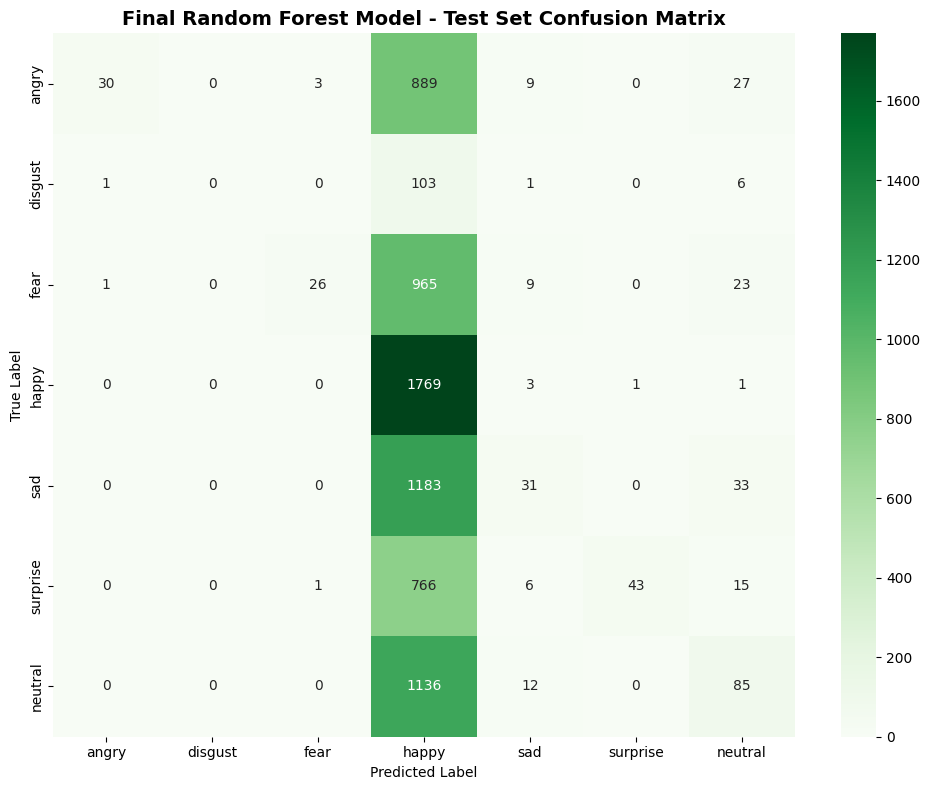

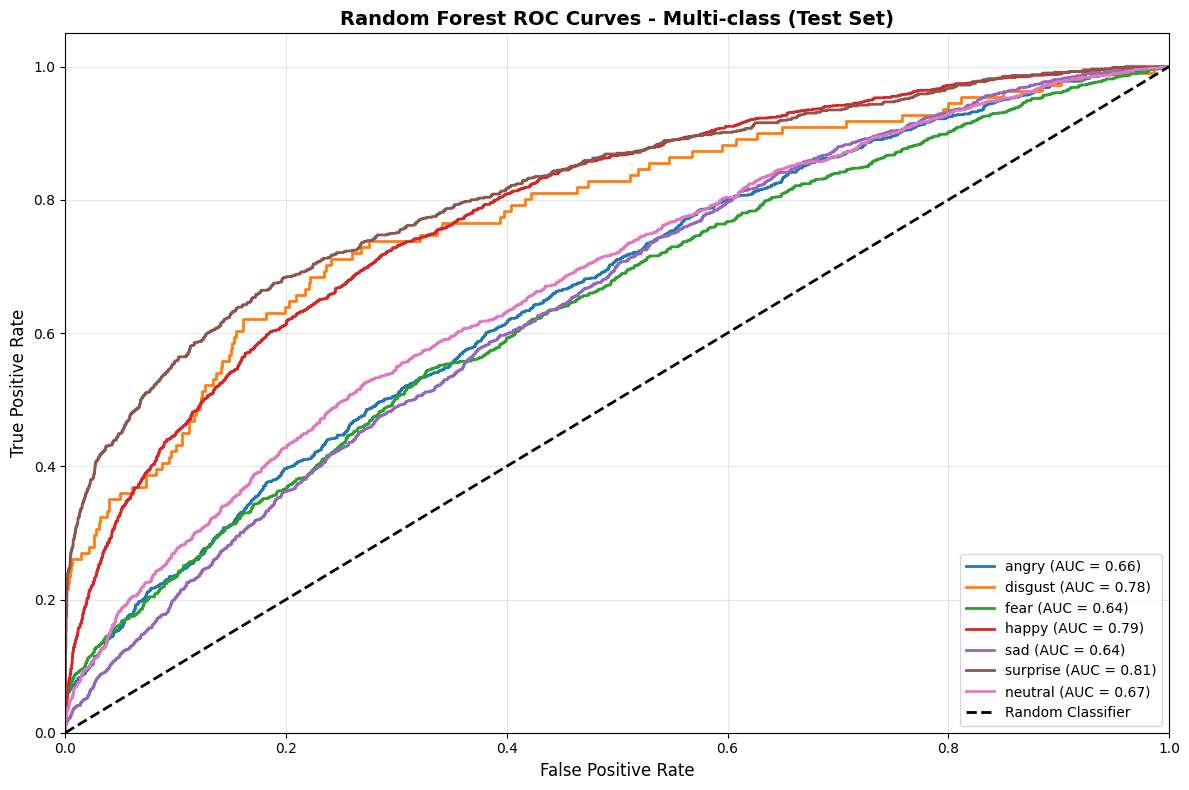

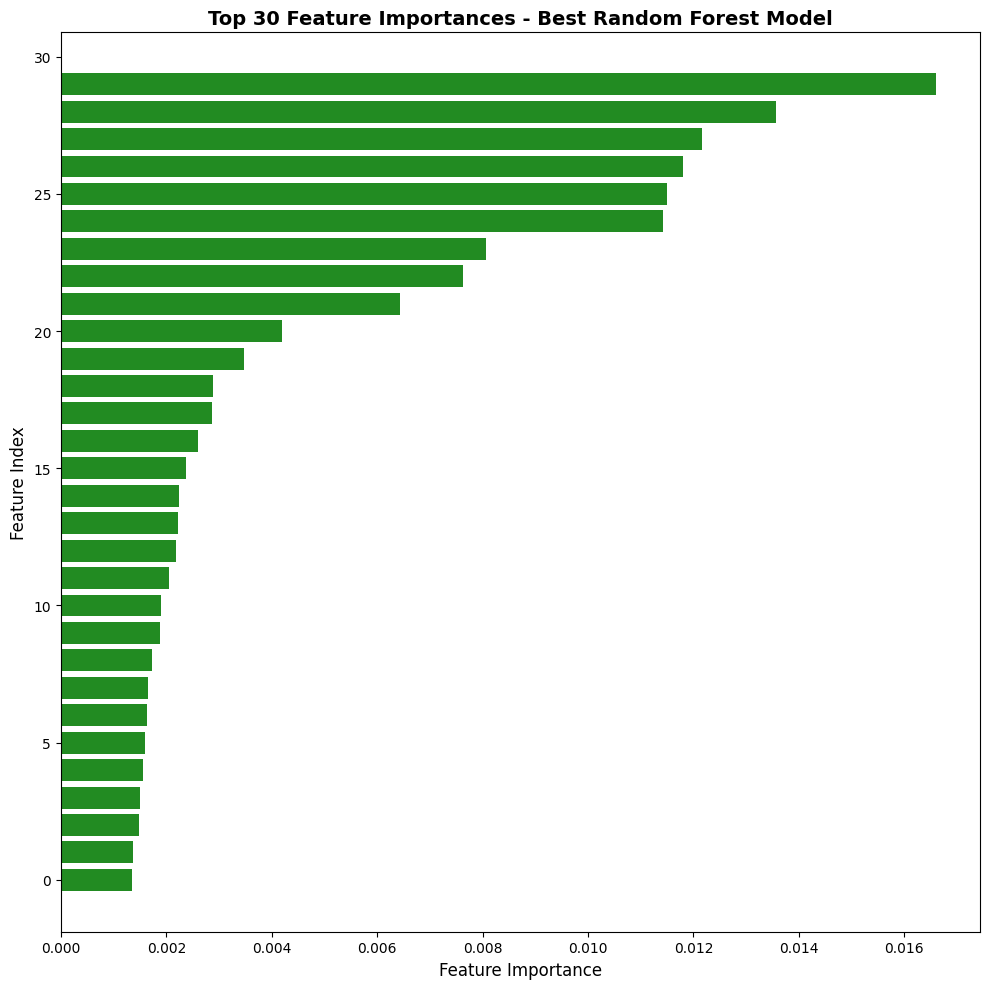


 Per-Class Metrics:
 Emotion  Precision   Recall  F1-Score  Support
   angry   0.937500 0.031315  0.060606      958
 disgust   0.000000 0.000000  0.000000      111
    fear   0.866667 0.025391  0.049336     1024
   happy   0.259727 0.997182  0.412114     1774
     sad   0.436620 0.024860  0.047041     1247
surprise   0.977273 0.051745  0.098286      831
 neutral   0.447368 0.068938  0.119466     1233

 Model saved: models/random_forest_best_20251112_042808.pkl
 Results saved: models/random_forest_results_20251112_042808.json

 RANDOM FOREST TRAINING PIPELINE COMPLETED SUCCESSFULLY

 Final Test Performance:
  ROC-AUC:  0.7139
  Accuracy: 0.2764
  F1-Score: 0.1124
 Model saved as: models/random_forest_best_20251112_042808.pkl


In [11]:

print("\n" + "="*70)
print(" FINAL RANDOM FOREST EVALUATION ON TEST SET")
print("="*70)

# Preprocess test data (independent)
X_test_processed_rf, test_info_rf = preprocessor.transform(X_test)
y_test_bin_rf = label_binarize(y_test, classes=range(n_classes_rf))





# Predict on test set
y_test_pred_rf = best_rf_model.predict(X_test_processed_rf)
y_test_pred_proba_rf = best_rf_model.predict_proba(X_test_processed_rf)

# Calculate all metrics
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_f1_macro_rf = f1_score(y_test, y_test_pred_rf, average='macro')
test_f1_weighted_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
test_roc_auc_rf = roc_auc_score(y_test_bin_rf, y_test_pred_proba_rf, average='macro', multi_class='ovr')

print("\nTest Set Metrics:")
print(f"  ROC-AUC (macro):     {test_roc_auc_rf:.4f}")
print(f"  Accuracy:            {test_accuracy_rf:.4f}")
print(f"  F1-Score (macro):    {test_f1_macro_rf:.4f}")
print(f"  F1-Score (weighted): {test_f1_weighted_rf:.4f}")



# Classification report
print("\n Test Classification Report:")
report_test_rf = classification_report(y_test, y_test_pred_rf, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_test, y_test_pred_rf, target_names=emotion_labels, digits=4))



# Confusion matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Final Random Forest Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix
test_cm_path_rf = 'rf_test_confusion_matrix.png'
plt.savefig(test_cm_path_rf, dpi=300, bbox_inches='tight')

plt.show()

# ROC Curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes_rf):
    fpr, tpr, _ = roc_curve(y_test_bin_rf[:, i], y_test_pred_proba_rf[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
    
  

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Log ROC curves
roc_path_rf = 'rf_test_roc_curves.png'
plt.savefig(roc_path_rf, dpi=300, bbox_inches='tight')

plt.show()

# Feature importance of best model
feature_importance_best = best_rf_model.feature_importances_
top_n = 30
top_indices_best = np.argsort(feature_importance_best)[-top_n:]

plt.figure(figsize=(10, 10))
plt.barh(range(top_n), feature_importance_best[top_indices_best], color='forestgreen')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature Index', fontsize=12)
plt.title(f'Top {top_n} Feature Importances - Best Random Forest Model', fontsize=14, fontweight='bold')
plt.tight_layout()

feat_imp_best_path = 'rf_best_feature_importance.png'
plt.savefig(feat_imp_best_path, dpi=300, bbox_inches='tight')

plt.show()

# Per-class metrics table
print("\n Per-Class Metrics:")
class_metrics_rf = []
for i, emotion in enumerate(emotion_labels):
    precision = cm_rf[i, i] / cm_rf[:, i].sum() if cm_rf[:, i].sum() > 0 else 0
    recall = cm_rf[i, i] / cm_rf[i, :].sum() if cm_rf[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_metrics_rf.append({
        'Emotion': emotion,
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-Score': float(f1),
        'Support': int(cm_rf[i, :].sum())
    })

class_metrics_df_rf = pd.DataFrame(class_metrics_rf)
print(class_metrics_df_rf.to_string(index=False))

# Save and log class metrics
class_metrics_csv_rf = "rf_test_class_metrics.csv"
class_metrics_df_rf.to_csv(class_metrics_csv_rf, index=False)


# Save final model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename_rf = f'models/random_forest_best_{timestamp}.pkl'
joblib.dump(best_rf_model, model_filename_rf)
print(f"\n Model saved: {model_filename_rf}")




# Save complete results
# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

final_results_rf = {
    'model_name': 'Random Forest',
    'timestamp': timestamp,
    'best_params': convert_to_native_types(best_params_rf),
    'best_run_id': best_run_id_rf,
    'validation_metrics': convert_to_native_types(best_metrics_rf),
    'test_metrics': {
        'roc_auc': float(test_roc_auc_rf),
        'accuracy': float(test_accuracy_rf),
        'f1_macro': float(test_f1_macro_rf),
        'f1_weighted': float(test_f1_weighted_rf)
    },
    'per_class_metrics': class_metrics_rf,
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test)),
    'feature_dimension': int(X_train_processed.shape[1]),
    'emotion_labels': emotion_labels
}

results_filename_rf = f'models/random_forest_results_{timestamp}.json'
with open(results_filename_rf, 'w') as f:
    json.dump(final_results_rf, f, indent=4)
print(f" Results saved: {results_filename_rf}")

print("\n" + "="*70)
print(" RANDOM FOREST TRAINING PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print("\n Final Test Performance:")
print(f"  ROC-AUC:  {test_roc_auc_rf:.4f}")
print(f"  Accuracy: {test_accuracy_rf:.4f}")
print(f"  F1-Score: {test_f1_macro_rf:.4f}")

print(f" Model saved as: {model_filename_rf}")


# SVM


 STEP 1: BASELINE SVM MODEL TRAINING

 Training baseline SVM model...
   Parameters: C=1.0, kernel=rbf, gamma=scale, class_weight=balanced
[LibSVM] Training completed!

 Training Set Performance:
   ROC-AUC (macro):     0.9818
   Accuracy:            0.8517
   F1-Score (macro):    0.8734
   F1-Score (weighted): 0.8517

 Validation Set Performance:
   ROC-AUC (macro):     0.8054
   Accuracy:            0.4775
   F1-Score (macro):    0.4523
   F1-Score (weighted): 0.4765

 Validation Classification Report:
              precision    recall  f1-score   support

       angry     0.3661    0.4105    0.3870       799
     disgust     0.9091    0.2299    0.3670        87
        fear     0.3875    0.3317    0.3574       820
       happy     0.6293    0.6528    0.6408      1443
         sad     0.3549    0.3913    0.3722       966
    surprise     0.6100    0.5994    0.6046       634
     neutral     0.4504    0.4250    0.4373       993

    accuracy                         0.4775      5742
 

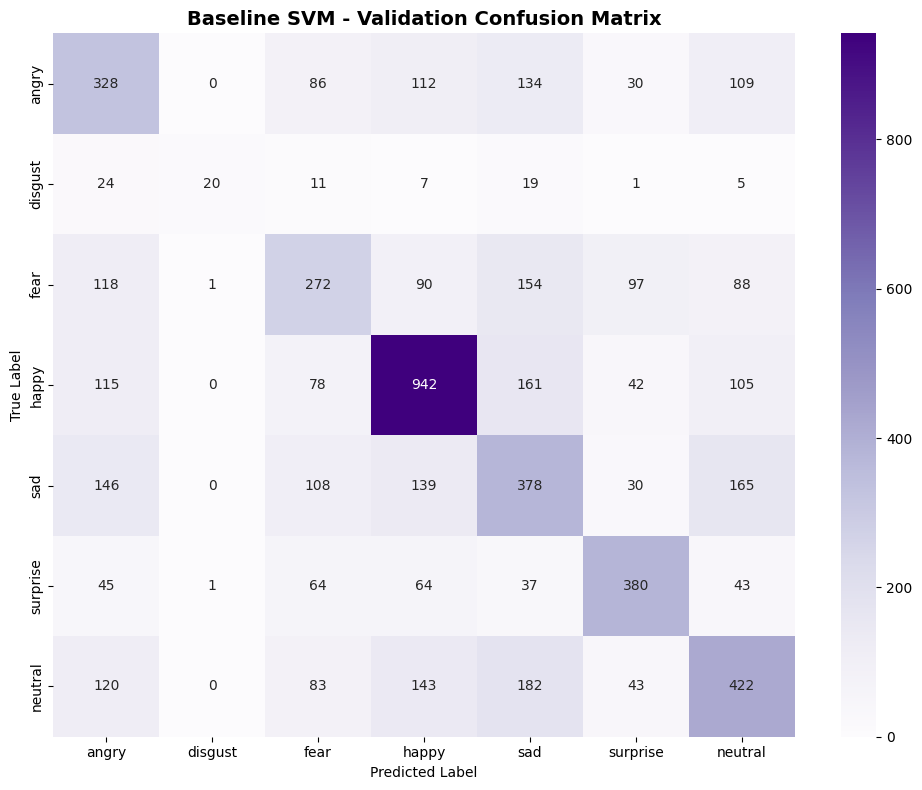


 BASELINE SVM MODEL EVALUATION COMPLETED

 Baseline Performance Summary:
   Training ROC-AUC:   0.9818
   Validation ROC-AUC: 0.8054
   Difference:         0.1765


In [12]:
# STEP 1: Train baseline SVM model
print("\n" + "="*70)
print(" STEP 1: BASELINE SVM MODEL TRAINING")
print("="*70)

# Prepare data for SVM (independent)
n_classes_svm = len(emotion_labels)
y_val_bin_svm = label_binarize(y_val, classes=range(n_classes_svm))
y_train_bin_svm = label_binarize(y_train, classes=range(n_classes_svm))


    


baseline_svm = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,  # Enable probability estimates for ROC-AUC
    random_state=42,
    verbose=True
)


print("\n Training baseline SVM model...")
print("   Parameters: C=1.0, kernel=rbf, gamma=scale, class_weight=balanced")

baseline_svm.fit(X_train_processed, y_train)
print(" Training completed!")

# Evaluate on training set
print("\n Training Set Performance:")
y_train_pred_svm = baseline_svm.predict(X_train_processed)
y_train_pred_proba_svm = baseline_svm.predict_proba(X_train_processed)

train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
train_f1_macro_svm = f1_score(y_train, y_train_pred_svm, average='macro')
train_f1_weighted_svm = f1_score(y_train, y_train_pred_svm, average='weighted')
train_roc_auc_svm = roc_auc_score(y_train_bin_svm, y_train_pred_proba_svm, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {train_roc_auc_svm:.4f}")
print(f"   Accuracy:            {train_accuracy_svm:.4f}")
print(f"   F1-Score (macro):    {train_f1_macro_svm:.4f}")
print(f"   F1-Score (weighted): {train_f1_weighted_svm:.4f}")



# Evaluate on validation set
print("\n Validation Set Performance:")
y_val_pred_svm = baseline_svm.predict(X_val_processed)
y_val_pred_proba_svm = baseline_svm.predict_proba(X_val_processed)

val_accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
val_f1_macro_svm = f1_score(y_val, y_val_pred_svm, average='macro')
val_f1_weighted_svm = f1_score(y_val, y_val_pred_svm, average='weighted')
val_roc_auc_svm = roc_auc_score(y_val_bin_svm, y_val_pred_proba_svm, average='macro', multi_class='ovr')

print(f"   ROC-AUC (macro):     {val_roc_auc_svm:.4f}")
print(f"   Accuracy:            {val_accuracy_svm:.4f}")
print(f"   F1-Score (macro):    {val_f1_macro_svm:.4f}")
print(f"   F1-Score (weighted): {val_f1_weighted_svm:.4f}")



# Classification report
print("\n Validation Classification Report:")
report_svm = classification_report(y_val, y_val_pred_svm, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_val, y_val_pred_svm, target_names=emotion_labels, digits=4))



# Confusion matrix visualization
cm_val_svm = confusion_matrix(y_val, y_val_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_svm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Baseline SVM - Validation Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix as artifact
cm_path_svm = "baseline_svm_confusion_matrix.png"
plt.savefig(cm_path_svm, dpi=300, bbox_inches='tight')

plt.show()



# Store baseline results
baseline_svm_results = {
    'train': {
        'roc_auc': train_roc_auc_svm,
        'accuracy': train_accuracy_svm,
        'f1_macro': train_f1_macro_svm,
        'f1_weighted': train_f1_weighted_svm
    },
    'validation': {
        'roc_auc': val_roc_auc_svm,
        'accuracy': val_accuracy_svm,
        'f1_macro': val_f1_macro_svm,
        'f1_weighted': val_f1_weighted_svm
    }
}

# Log baseline results as JSON artifact
baseline_svm_json = "baseline_svm_results.json"
with open(baseline_svm_json, 'w') as f:
    json.dump(baseline_svm_results, f, indent=4)


print("\n" + "="*70)
print(" BASELINE SVM MODEL EVALUATION COMPLETED")
print("="*70)
print("\n Baseline Performance Summary:")
print(f"   Training ROC-AUC:   {train_roc_auc_svm:.4f}")
print(f"   Validation ROC-AUC: {val_roc_auc_svm:.4f}")
print(f"   Difference:         {abs(train_roc_auc_svm - val_roc_auc_svm):.4f}")

# Log overfitting metric
overfitting_gap_svm = train_roc_auc_svm - val_roc_auc_svm


if train_roc_auc_svm - val_roc_auc_svm > 0.05:
    print("     Warning: Possible overfitting detected!")




In [ ]:
# STEP 2: Hyperparameter Tuning for SVM using RandomizedSearchCV (Demo)
print("\n" + "="*70)
print(" STEP 2: HYPERPARAMETER TUNING FOR SVM")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

# Reduced hyperparameter distributions for demo (faster execution)
param_distributions_svm = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

print("\n Parameter Distributions (Demo - Limited for faster execution):")
for param, dist in param_distributions_svm.items():
    print(f"   {param}: {dist}")

n_iter_svm = 10  # Number of random combinations to try (reduced for demo)
print(f"\nRandomized Search iterations: {n_iter_svm} (demo mode)")
print(f"Baseline ROC-AUC to beat: {val_roc_auc_svm:.4f}\n")



# Create RandomizedSearchCV
svm_random = RandomizedSearchCV(
    estimator=SVC(probability=True, random_state=42, class_weight='balanced'),
    param_distributions=param_distributions_svm,
    n_iter=n_iter_svm,
    cv=3,  # 3-fold cross-validation on training data
    scoring='roc_auc_ovr',  # ROC-AUC one-vs-rest
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV
print(" Running RandomizedSearchCV (should complete in a few minutes)...")
svm_random.fit(X_train_processed, y_train)
print(" RandomizedSearchCV completed!")

# Get results
cv_results = pd.DataFrame(svm_random.cv_results_)
cv_results = cv_results.sort_values('rank_test_score')



results_list_svm = []
best_roc_auc_svm = val_roc_auc_svm
best_svm_model = baseline_svm
best_run_id_svm = None
best_params_svm = {}  # Initialize to prevent NameError
best_metrics_svm = {  # Initialize with baseline metrics
    'val_roc_auc': val_roc_auc_svm,
    'val_accuracy': val_accuracy_svm,
    'val_f1_macro': val_f1_macro_svm,
    'val_f1_weighted': val_f1_weighted_svm
}

for idx in range(len(cv_results)):
    row = cv_results.iloc[idx]
    
    
        
    # Extract parameters
    params = {k.replace('param_', ''): v for k, v in row.items() if k.startswith('param_')}
    
   
    
    # Get the model from CV
    model_idx = row['rank_test_score'] - 1
    model_svm = svm_random.cv_results_['params'][model_idx]
    fitted_model = SVC(**model_svm, probability=True, random_state=42, class_weight='balanced')
    fitted_model.fit(X_train_processed, y_train)
    
    # Evaluate on validation set
    y_val_pred = fitted_model.predict(X_val_processed)
    y_val_pred_proba = fitted_model.predict_proba(X_val_processed)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val_bin_svm, y_val_pred_proba, average='macro', multi_class='ovr')
    accuracy = accuracy_score(y_val, y_val_pred)
    f1_macro = f1_score(y_val, y_val_pred, average='macro')
    f1_weighted = f1_score(y_val, y_val_pred, average='weighted')
    
   
    
    # Store results
    result = {
        
        **params,
        'cv_mean_score': row['mean_test_score'],
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    results_list_svm.append(result)
    
    # Update best model
    if roc_auc > best_roc_auc_svm:
        improvement = roc_auc - best_roc_auc_svm
        best_roc_auc_svm = roc_auc
        best_svm_model = fitted_model
       
        best_params_svm = params
        best_metrics_svm = {
            'val_roc_auc': roc_auc,
            'val_accuracy': accuracy,
            'val_f1_macro': f1_macro,
            'val_f1_weighted': f1_weighted
        }
       
       
        
        print(f" New best SVM model found! (+{improvement:.4f})")
        print(f"   ROC-AUC: {roc_auc:.4f} | Accuracy: {accuracy:.4f} | F1-Macro: {f1_macro:.4f}")
        print(f"   CV Score: {row['mean_test_score']:.4f}")
   





# Save CV results
cv_results_path = "svm_cv_results.csv"
cv_results.to_csv(cv_results_path, index=False)


print("\n" + "="*70)
print(" RANDOMIZED HYPERPARAMETER TUNING COMPLETED")
print("="*70)

improvement_svm = best_roc_auc_svm - baseline_svm_results['validation']['roc_auc']
print("\n Tuning Results:")
print(f"   Baseline ROC-AUC:     {baseline_svm_results['validation']['roc_auc']:.4f}")
print(f"   Best CV ROC-AUC:      {svm_random.best_score_:.4f}")
print(f"   Best Val ROC-AUC:     {best_roc_auc_svm:.4f}")
print(f"   Improvement:          {improvement_svm:.4f} ({improvement_svm/baseline_svm_results['validation']['roc_auc']*100:.2f}%)")
print(f"   Iterations completed: {n_iter_svm}")



 STEP 2: HYPERPARAMETER TUNING FOR SVM

 Parameter Distributions (Demo - Limited for faster execution):
   C: [0.1, 1.0, 10.0]
   kernel: ['rbf', 'linear']
   gamma: ['scale', 'auto']

Randomized Search iterations: 10 (demo mode)
Baseline ROC-AUC to beat: 0.8054

 Running RandomizedSearchCV (should complete in a few minutes)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [1]:


results_df_svm = pd.DataFrame(results_list_svm)
results_df_svm = results_df_svm.sort_values('roc_auc', ascending=False)

print("\n TOP 10 SVM MODELS BY VALIDATION ROC-AUC:")
display_cols = ['cv_mean_score', 'roc_auc', 'accuracy', 'f1_macro', 'C', 'kernel', 'gamma']
available_cols = [col for col in display_cols if col in results_df_svm.columns]
print(results_df_svm[available_cols].head(10).to_string(index=False))

# Save results to CSV and log as artifact
results_csv_svm = "svm_randomized_search_results.csv"
results_df_svm.to_csv(results_csv_svm, index=False)


# Visualize tuning results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC-AUC distribution
ax1 = axes[0, 0]
ax1.hist(results_df_svm['roc_auc'], bins=15, edgecolor='black', alpha=0.7, color='mediumpurple')
ax1.axvline(baseline_svm_results['validation']['roc_auc'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.axvline(best_roc_auc_svm, color='darkviolet', linestyle='--', linewidth=2, label='Best')
ax1.set_xlabel('Validation ROC-AUC', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Validation ROC-AUC Scores', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. CV Score vs Validation Score
ax2 = axes[0, 1]
ax2.scatter(results_df_svm['cv_mean_score'], results_df_svm['roc_auc'], 
            alpha=0.6, s=100, c='purple', edgecolors='black')
ax2.plot([results_df_svm['cv_mean_score'].min(), results_df_svm['cv_mean_score'].max()],
            [results_df_svm['cv_mean_score'].min(), results_df_svm['cv_mean_score'].max()],
            'r--', lw=2, label='Perfect correlation')
ax2.set_xlabel('CV Mean Score (3-fold)', fontsize=12)
ax2.set_ylabel('Validation ROC-AUC', fontsize=12)
ax2.set_title('CV Score vs Validation Score', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. C parameter effect (if available)
ax3 = axes[1, 0]
if 'C' in results_df_svm.columns:
    c_effect = results_df_svm.groupby('C')['roc_auc'].agg(['mean', 'std']).reset_index()
    ax3.errorbar(c_effect['C'], c_effect['mean'], yerr=c_effect['std'], marker='o', capsize=5, capthick=2, linewidth=2, color='purple')
    ax3.set_xscale('log')
    ax3.set_xlabel('C (Regularization)', fontsize=12)
    ax3.set_ylabel('Validation ROC-AUC', fontsize=12)
    ax3.set_title('Effect of C Parameter', fontsize=14, fontweight='bold')
    ax3.grid(alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'C parameter data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax3.axis('off')

# 4. Kernel comparison
ax4 = axes[1, 1]
if 'kernel' in results_df_svm.columns:
    kernel_comparison = results_df_svm.groupby('kernel')['roc_auc'].apply(list).to_dict()
    if kernel_comparison:
        ax4.boxplot(kernel_comparison.values(), labels=kernel_comparison.keys())
        ax4.set_ylabel('Validation ROC-AUC', fontsize=12)
        ax4.set_title('Kernel Comparison', fontsize=14, fontweight='bold')
        ax4.grid(alpha=0.3, axis='y')
    else:
        ax4.text(0.5, 0.5, 'Kernel comparison\nnot available', 
                ha='center', va='center', fontsize=12)
        ax4.axis('off')
else:
    ax4.text(0.5, 0.5, 'Kernel data\nnot available', 
            ha='center', va='center', fontsize=12)
    ax4.axis('off')

plt.tight_layout()

# Log visualization as artifact
tuning_viz_path_svm = 'svm_randomized_search_analysis.png'
plt.savefig(tuning_viz_path_svm, dpi=300, bbox_inches='tight')

plt.show()

print("\n" + "="*70)
print(" BEST SVM MODEL PARAMETERS (from RandomizedSearchCV)")
print("="*70)
print("\nBest Parameters:")
for key, value in best_params_svm.items():
    print(f"  {key}: {value}")

print("\nValidation Metrics:")
for key, value in best_metrics_svm.items():
    print(f"  {key}: {value:.4f}")



NameError: name 'pd' is not defined


 FINAL SVM EVALUATION ON TEST SET

🔄 TEST DATA PREPROCESSING PIPELINE

[1/8] Median Filter
  → Applying Median Filter...


Median Filter: 100%|██████████| 140/140 [00:00<00:00, 54310.26it/s]



[2/8] CLAHE Enhancement
  → Applying CLAHE Enhancement...


CLAHE: 100%|██████████| 140/140 [00:00<00:00, 16380.80it/s]



[3/8] Resize and Normalize
  → Resizing to (64, 64) and Normalizing...


Resize: 100%|██████████| 140/140 [00:00<00:00, 55743.55it/s]



[4/8] HOG Feature Extraction
  → Extracting HOG Features...


HOG: 100%|██████████| 140/140 [00:00<00:00, 788.41it/s]


    HOG shape: (140, 1764)

[5/8] LBP Feature Extraction
  → Extracting LBP Features...


LBP:   0%|          | 0/140 [00:00<?, ?it/s]c:\Users\nguye\miniconda3\envs\hrt\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
LBP: 100%|██████████| 140/140 [00:00<00:00, 369.99it/s]


    LBP shape: (140, 640)

[6/8] SIFT Feature Extraction
  → Extracting SIFT Features...


SIFT: 100%|██████████| 140/140 [00:00<00:00, 580.08it/s]


    SIFT shape: (140, 1280)

[7/8] Combining Features (HOG + LBP + SIFT)
  → Combined shape: (140, 3684)

[8/8] Standard Scaling and PCA
  → Applying fitted StandardScaler...
  → Applying fitted PCA...

✅ TEST PREPROCESSING COMPLETED
Final shape: (140, 436)
Original samples: 140

Test Set Metrics:
  ROC-AUC (macro):     0.6463
  Accuracy:            0.2643
  F1-Score (macro):    0.2613
  F1-Score (weighted): 0.2613

 Test Classification Report:
              precision    recall  f1-score   support

       angry     0.2667    0.2000    0.2286        20
     disgust     0.4348    0.5000    0.4651        20
        fear     0.4000    0.1000    0.1600        20
       happy     0.1750    0.3500    0.2333        20
         sad     0.1818    0.1000    0.1290        20
    surprise     0.5385    0.3500    0.4242        20
     neutral     0.1515    0.2500    0.1887        20

    accuracy                         0.2643       140
   macro avg     0.3069    0.2643    0.2613       140
weighted 

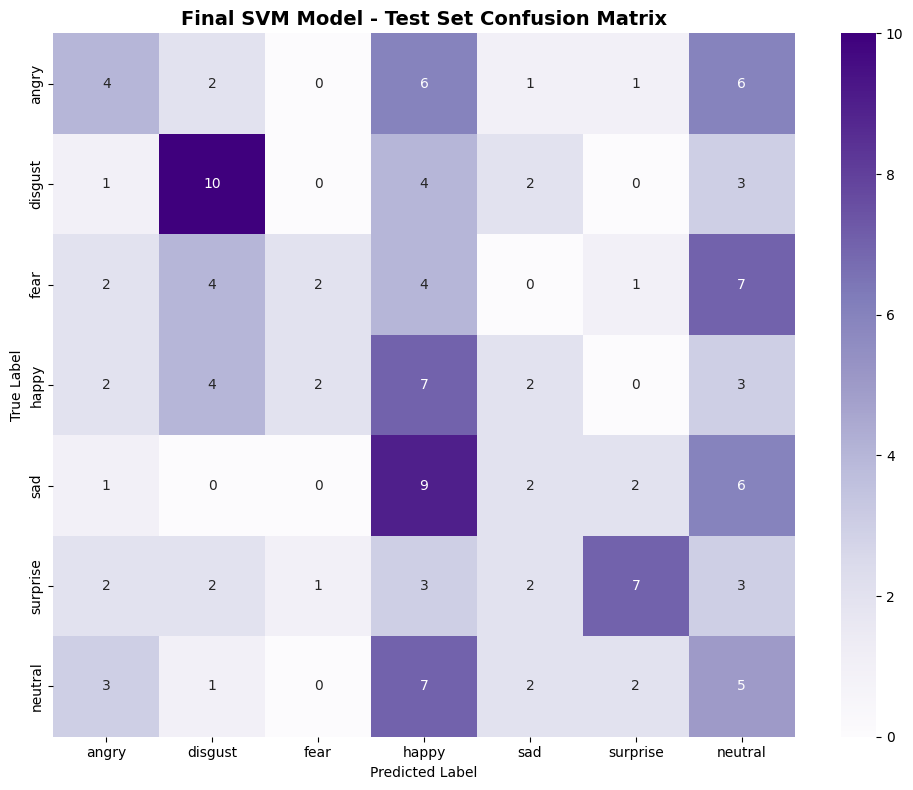

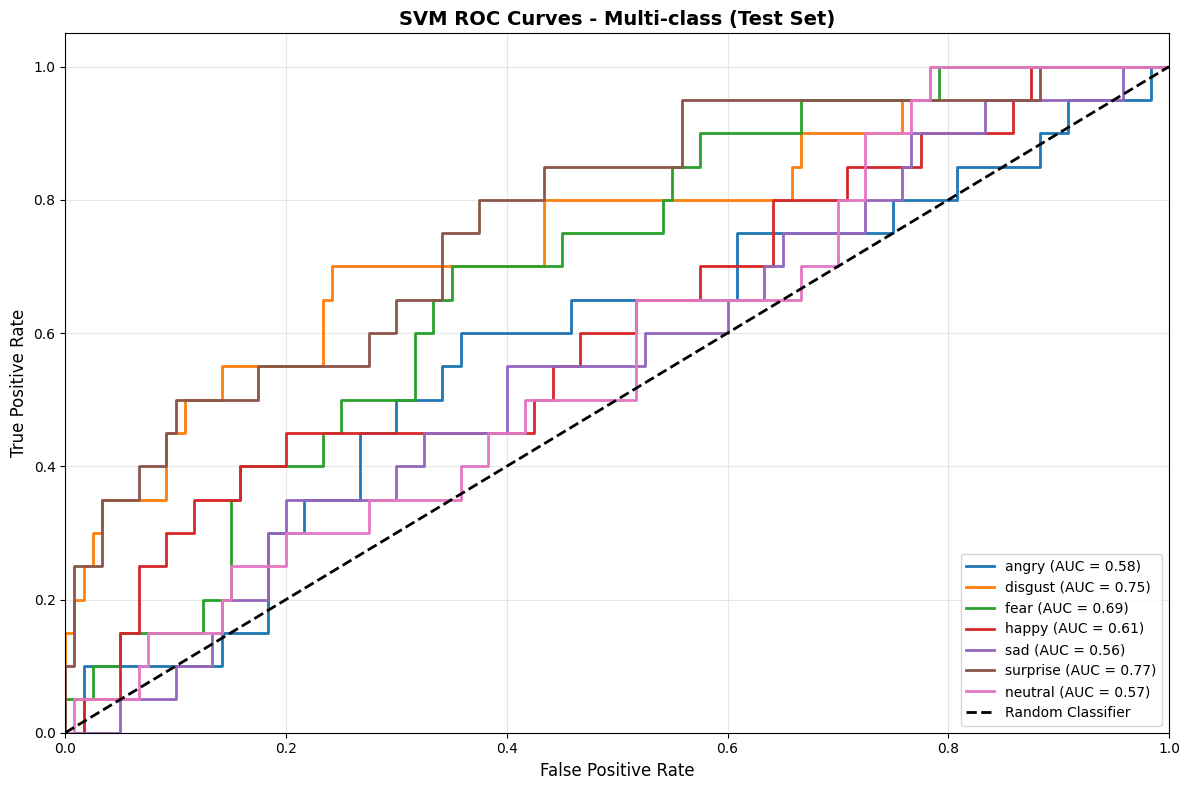


 Per-Class Metrics:
 Emotion  Precision  Recall  F1-Score  Support
   angry   0.266667    0.20  0.228571       20
 disgust   0.434783    0.50  0.465116       20
    fear   0.400000    0.10  0.160000       20
   happy   0.175000    0.35  0.233333       20
     sad   0.181818    0.10  0.129032       20
surprise   0.538462    0.35  0.424242       20
 neutral   0.151515    0.25  0.188679       20

 Model saved: models/svm_best_20251112_032214.pkl
 Results saved: models/svm_results_20251112_032214.json

 SVM TRAINING PIPELINE COMPLETED SUCCESSFULLY

 Final Test Performance:
  ROC-AUC:  0.6463
  Accuracy: 0.2643
  F1-Score: 0.2613
 Model saved as: models/svm_best_20251112_032214.pkl


In [ ]:

print("\n" + "="*70)
print(" FINAL SVM EVALUATION ON TEST SET")
print("="*70)

# Preprocess test data (independent)
X_test_processed_svm, test_info_svm = preprocessor.transform(X_test)
y_test_bin_svm = label_binarize(y_test, classes=range(n_classes_svm))




# Predict on test set
y_test_pred_svm = best_svm_model.predict(X_test_processed_svm)
y_test_pred_proba_svm = best_svm_model.predict_proba(X_test_processed_svm)

# Calculate all metrics
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_f1_macro_svm = f1_score(y_test, y_test_pred_svm, average='macro')
test_f1_weighted_svm = f1_score(y_test, y_test_pred_svm, average='weighted')
test_roc_auc_svm = roc_auc_score(y_test_bin_svm, y_test_pred_proba_svm, average='macro', multi_class='ovr')

print("\nTest Set Metrics:")
print(f"  ROC-AUC (macro):     {test_roc_auc_svm:.4f}")
print(f"  Accuracy:            {test_accuracy_svm:.4f}")
print(f"  F1-Score (macro):    {test_f1_macro_svm:.4f}")
print(f"  F1-Score (weighted): {test_f1_weighted_svm:.4f}")



# Classification report
print("\n Test Classification Report:")
report_test_svm = classification_report(y_test, y_test_pred_svm, target_names=emotion_labels, digits=4, output_dict=True)
print(classification_report(y_test, y_test_pred_svm, target_names=emotion_labels, digits=4))



# Confusion matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Final SVM Model - Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Log confusion matrix
test_cm_path_svm = 'svm_test_confusion_matrix.png'
plt.savefig(test_cm_path_svm, dpi=300, bbox_inches='tight')

plt.show()

# ROC Curves for each class
plt.figure(figsize=(12, 8))
for i in range(n_classes_svm):
    fpr, tpr, _ = roc_curve(y_test_bin_svm[:, i], y_test_pred_proba_svm[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{emotion_labels[i]} (AUC = {roc_auc_class:.2f})')
    


plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('SVM ROC Curves - Multi-class (Test Set)', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Log ROC curves
roc_path_svm = 'svm_test_roc_curves.png'
plt.savefig(roc_path_svm, dpi=300, bbox_inches='tight')

plt.show()

# Per-class metrics table
print("\n Per-Class Metrics:")
class_metrics_svm = []
for i, emotion in enumerate(emotion_labels):
    precision = cm_svm[i, i] / cm_svm[:, i].sum() if cm_svm[:, i].sum() > 0 else 0
    recall = cm_svm[i, i] / cm_svm[i, :].sum() if cm_svm[i, :].sum() > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    class_metrics_svm.append({
        'Emotion': emotion,
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-Score': float(f1),
        'Support': int(cm_svm[i, :].sum())
    })

class_metrics_df_svm = pd.DataFrame(class_metrics_svm)
print(class_metrics_df_svm.to_string(index=False))

# Save and log class metrics
class_metrics_csv_svm = "svm_test_class_metrics.csv"
class_metrics_df_svm.to_csv(class_metrics_csv_svm, index=False)


# Save final model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename_svm = f'models/svm_best_{timestamp}.pkl'
joblib.dump(best_svm_model, model_filename_svm)
print(f"\n Model saved: {model_filename_svm}")




# Save complete results
# Helper function to convert numpy types to native Python types
def convert_to_native_types(obj):
    """Recursively convert numpy types to native Python types"""
    if isinstance(obj, dict):
        return {k: convert_to_native_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native_types(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

final_results_svm = {
    'model_name': 'SVM',
    'timestamp': timestamp,
    'best_params': convert_to_native_types(best_params_svm),
    'best_run_id': best_run_id_svm,
    'validation_metrics': convert_to_native_types(best_metrics_svm),
    'test_metrics': {
        'roc_auc': float(test_roc_auc_svm),
        'accuracy': float(test_accuracy_svm),
        'f1_macro': float(test_f1_macro_svm),
        'f1_weighted': float(test_f1_weighted_svm)
    },
    'per_class_metrics': class_metrics_svm,
    'training_samples': int(len(X_train)),
    'validation_samples': int(len(X_val)),
    'test_samples': int(len(X_test)),
    'feature_dimension': int(X_train_processed.shape[1]),
    'emotion_labels': emotion_labels
}

results_filename_svm = f'models/svm_results_{timestamp}.json'
with open(results_filename_svm, 'w') as f:
    json.dump(final_results_svm, f, indent=4)
print(f" Results saved: {results_filename_svm}")



print("\n" + "="*70)
print(" SVM TRAINING PIPELINE COMPLETED SUCCESSFULLY")
print("="*70)
print("\n Final Test Performance:")
print(f"  ROC-AUC:  {test_roc_auc_svm:.4f}")
print(f"  Accuracy: {test_accuracy_svm:.4f}")
print(f"  F1-Score: {test_f1_macro_svm:.4f}")

print(f" Model saved as: {model_filename_svm}")
